# Filtro de Kalman. 
## Estimación de la trayectoria de un vehículo

In [280]:
import numpy as np 
import matplotlib.pyplot as plt

In [281]:
# paso de medición
h = 1

# número de variables de estado
nx = 9

# número de variables medidas
mc = 3

In [282]:
## Carga de datos
position = np.loadtxt('./posicion.dat')
velocity = np.loadtxt('./velocidad.dat')
acceleration = np.loadtxt('./aceleracion.dat')

n_samples = len(position)

X = np.concatenate((position,velocity,acceleration), axis=1)
X.shape

(351, 9)

## 1 - Midiendo solamente la posición, con ruido gaussiano

In [283]:
## matriz de transición
# Coeficientes ecuaciones de posición
coef_pos = np.concatenate((np.identity(mc), h*np.identity(mc), h**2/2 * np.identity(mc)), axis=1)
# Coeficientes ecuaciones de velocidad
coef_vel = np.concatenate((np.zeros((mc,mc)), np.identity(mc), h*np.identity(mc)), axis=1)
# Coeficientes ecuaciones de aceleración
coef_acc = np.concatenate((np.zeros((mc,mc)), np.zeros((mc,mc)), np.identity(mc)), axis=1)

# matriz de transición
A = np.concatenate((coef_pos, coef_vel, coef_acc))
assert A.shape == (nx, nx)

In [284]:
## Matriz de observación
C = np.concatenate((np.identity(mc), np.zeros((mc,mc)), np.zeros((mc,mc))), axis=1)
assert C.shape == (mc, nx)

In [285]:
## Condiciones iniciales
# estimación a posteriori inicial
x_posteriori_0 = np.array([10.7533, 36.6777, -45.1769, 1.1009, -17.0, 35.7418, -5.7247, 3.4268, 5.2774], ndmin=2).T
assert x_posteriori_0.shape == (nx, 1)

# matriz de covarianza (relacionado con el error de estimación)
P_posteriori_0 = np.diag(np.array([100, 100, 100, 1, 1, 1, 0.01, 0.01, 0.01]))
assert P_posteriori_0.shape == (nx, nx)

# estimación a priori incial (valores random enteros entre 0 y 1000)
x_priori_0 = np.random.default_rng(seed=42).integers(low=0, high=1000, size=(nx,1))
assert x_priori_0.shape == (nx, 1)

# matriz de covarianza a priori
P_priori_0 = 10*np.ones((nx,nx))
assert P_priori_0.shape == (nx, nx)

In [286]:
## ruidos
Q = 0.3 * np.identity(nx)                # Se considera constante a lo largo de todo el experimento.
assert Q.shape == (nx, nx)

R = np.diag(np.array([100, 100, 100]))  # Se considera constante a lo largo de todo el experimento.
assert R.shape == (mc, mc)

In [287]:
## Iteración filtro de Kalman
x_priori = [x_priori_0]
y = [np.zeros((mc,1))]
y_priori = [C.dot(x_priori_0)]
P_priori = [P_priori_0]
#P_priori = [10*np.identity(nx)]
x_posteriori = [x_posteriori_0]
P_posteriori = [P_posteriori_0]


for k in range(len(position)-1):
    ## Estimación a priori - predicción
    x_priori_k = A.dot(x_posteriori[-1])
    y_priori_k = C.dot(x_priori_k)
    P_priori_k = A.dot(P_posteriori[-1]).dot(A.T) + Q
    ## Estimación a posteriori - corrección
    # ruido blanco de medicion (uno para cada posición en ppio.)
    w_k = np.random.normal(0, 10, (3,1))
    R_k = R
    K_k = P_priori_k.dot(C.T).dot(np.linalg.inv(R_k + C.dot(P_priori_k).dot(C.T)))
    # valores de estado reales en instante k
    x_k = np.concatenate((position[k].reshape((3,1)), velocity[k].reshape((3,1)), acceleration[k].reshape((3,1))), axis=0)
    y_k = C.dot(x_k) + w_k
    x_posteriori_k = x_priori_k + K_k.dot(y_k - C.dot(x_priori_k))
    P_posteriori_k = (np.identity(9) - K_k.dot(C)).dot(P_priori_k)

    x_priori.append(x_priori_k)
    y_priori.append(y_priori_k)
    P_priori.append(P_priori_k)
    x_posteriori.append(x_posteriori_k)
    P_posteriori.append(P_posteriori_k)
    y.append(y_k)

# lists as numpy arrays
x_priori = np.array(x_priori).squeeze()
y_priori = np.array(y_priori).squeeze()
P_priori = np.array(P_priori)
x_posteriori = np.array(x_posteriori).squeeze()
P_posteriori = np.array(P_posteriori)
y = np.array(y).squeeze()

### Análisis del ruido

Text(0.5, 1.0, 'position Z')

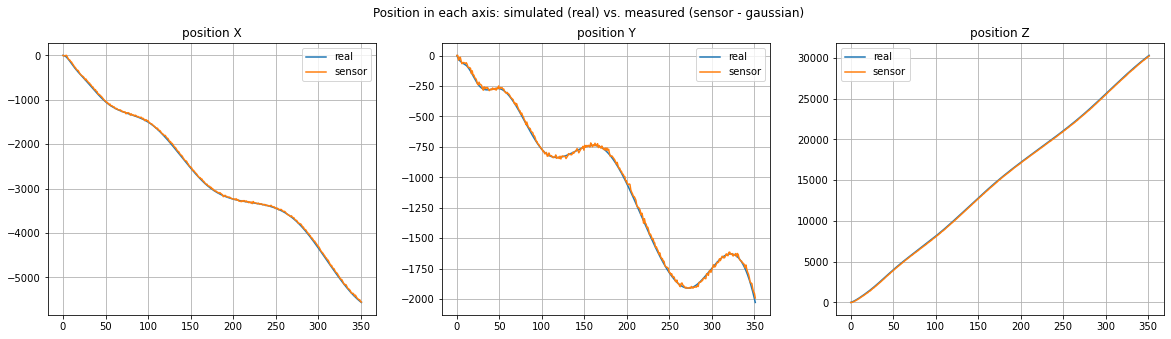

In [288]:
## Comparación señal simulada real vs señal medida con ruido gaussiano
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle('Position in each axis: simulated (real) vs. measured (sensor - gaussian)')

axs[0].plot(x_scale, position[:,0])
axs[0].plot(x_scale, y[:,0])
axs[0].legend(["real", "sensor"], loc='best')
axs[0].grid()
axs[0].set_title("position X")

axs[1].plot(x_scale, position[:,1], label='pos_y real')
axs[1].plot(x_scale, y[:,1], label='pos_y sensor')
axs[1].legend(["real", "sensor"], loc='best')
axs[1].grid()
axs[1].set_title("position Y")

axs[2].plot(x_scale, position[:,2], label='pos_z real')
axs[2].plot(x_scale, y[:,2], label='pos_z sensor')
axs[2].legend(["real", "sensor"], loc='best')
axs[2].grid()
axs[2].set_title("position Z")


Text(0.5, 1.0, 'error Z')

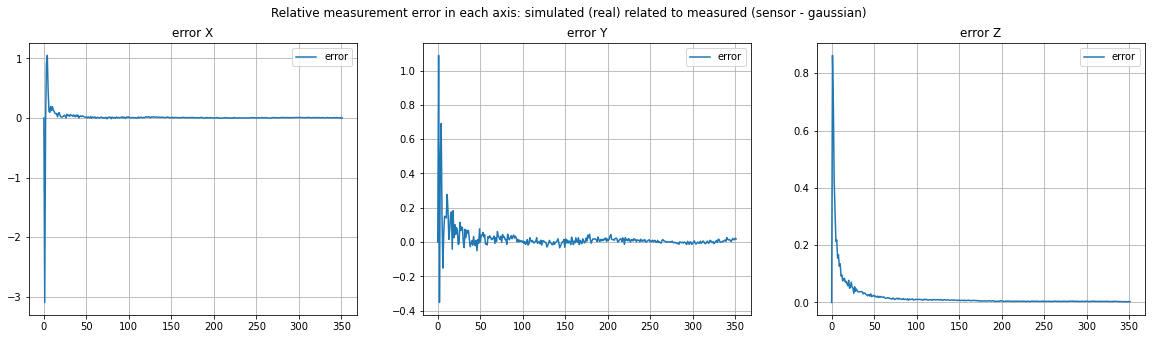

In [292]:
## Error relativo señal simulada real vs señal medida con ruido gaussiano
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle('Relative measurement error in each axis: simulated (real) related to measured (sensor - gaussian)')

axs[0].plot(x_scale, (position[:,0]-y[:,0])/(position[:,0]+0.00001))
axs[0].legend(["error"], loc='best')
axs[0].grid()
axs[0].set_title("error X")

axs[1].plot(x_scale, (position[:,1]-y[:,1])/(position[:,1]+0.00001))
axs[1].legend(["error"], loc='best')
axs[1].grid()
axs[1].set_title("error Y")

axs[2].plot(x_scale, (position[:,2]-y[:,2])/(position[:,2]+0.00001))
axs[2].legend(["error"], loc='best')
axs[2].grid()
axs[2].set_title("error Z")

In [290]:
max_error = np.max((position[:,0]-y[:,0])/(position[:,0]+0.0001))
mean_error = np.mean((position[:,0]-y[:,0])/(position[:,0]+0.0001))
print(max_error)
print(mean_error)

1.050505037797653
0.009395660497432337


#### Conlusión
Como es de esperarse el valor medio del error relativo de medición es cercano a cero ya que la media del ruido es cero.
En los periodos iniciales el error es muy grande debido a la diferencia en las condiciones iniciales. A medida que pasa el tiempo el filtro hace su efecto.

### Comparación entre $\hat{x}_{k|k}$, $\hat{x}_{k|k-1}$ y $x_k$

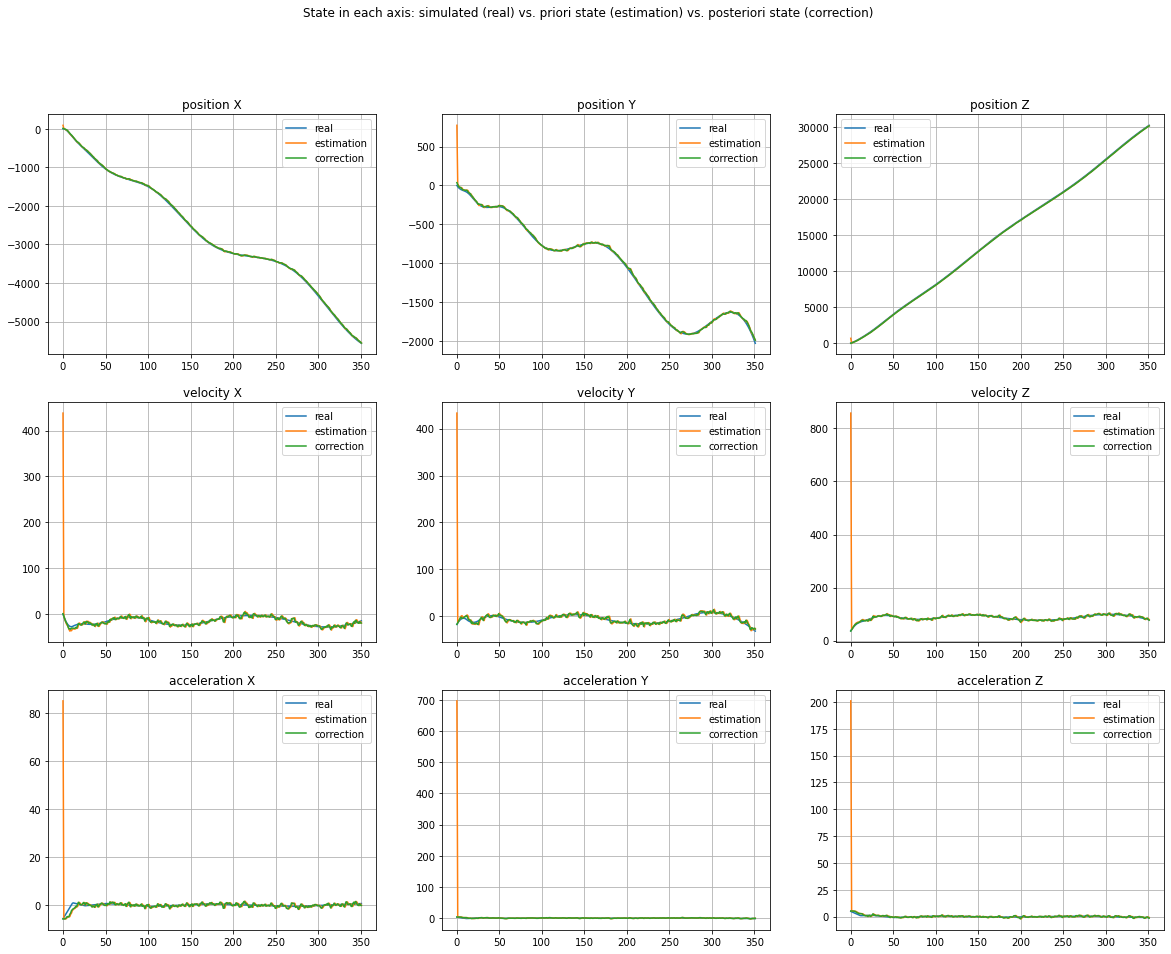

In [293]:
## Comparación señal simulada real vs señal medida con ruido gaussiano vs. posición estimada vs. posición corregida
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(3, 3, figsize=(20,15))
fig.suptitle('State in each axis: simulated (real) vs. priori state (estimation) vs. posteriori state (correction)')

for i in range(len(axs)):
    for j in range(len(axs[i])):
        axs[i,j].plot(x_scale, X[:,3*i+j])
        axs[i,j].plot(x_scale, x_priori[:,3*i+j])
        axs[i,j].plot(x_scale, x_posteriori[:,3*i+j])
        axs[i,j].legend(["real", "estimation", "correction"], loc='best')
        axs[i,j].grid()
        title = ''
        if i == 0:
            title = 'position'
        elif i == 1:
            title = 'velocity'
        elif i == 2:
            title = 'acceleration'
        if j == 0:
            title += ' X'
        elif j == 1:
            title += ' Y'
        elif j == 2:
            title += ' Z'
        
        axs[i,j].set_title(title)

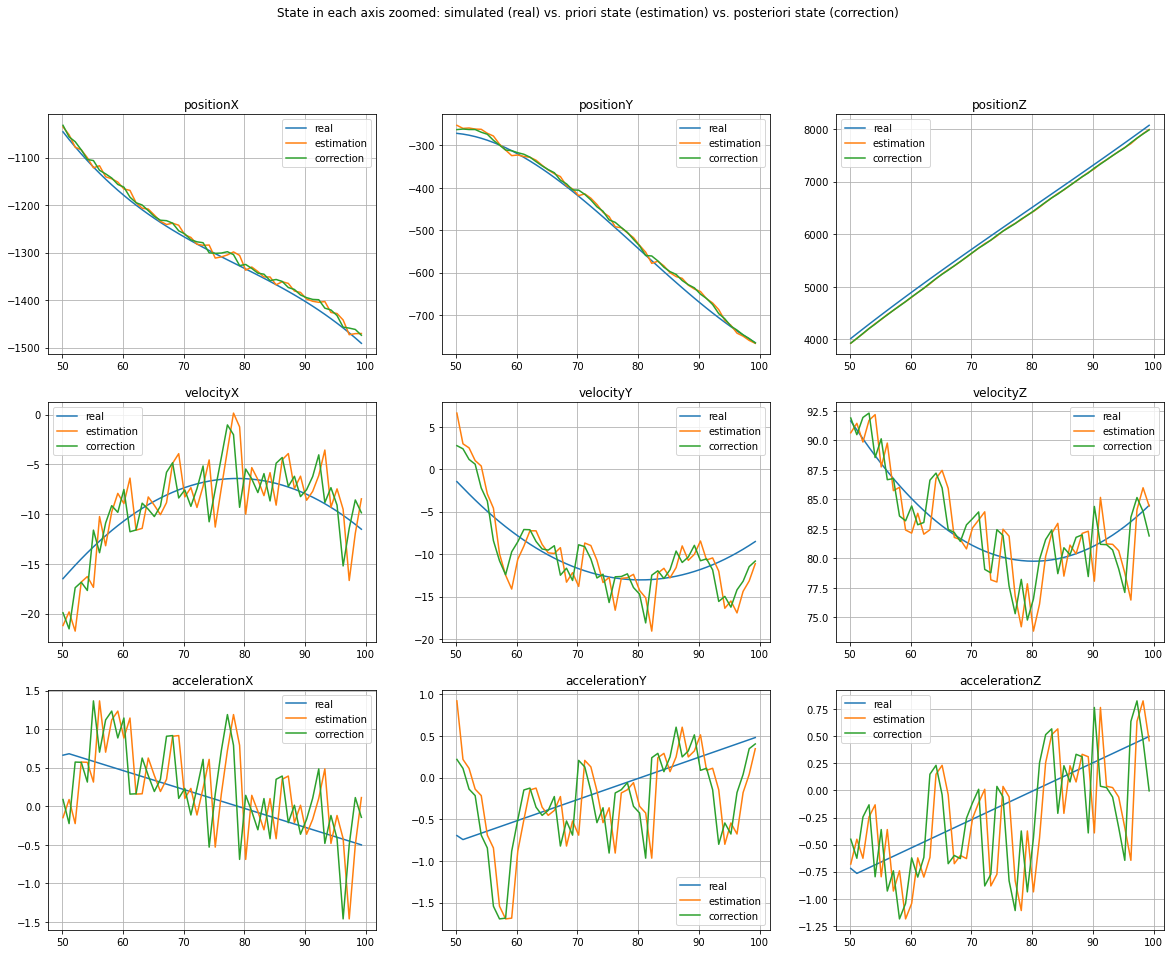

In [294]:
## (Zoom) Comparación señal simulada real vs señal medida con ruido gaussiano vs. posición estimada vs. posición corregida
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(3, 3, figsize=(20,15))
fig.suptitle('State in each axis zoomed: simulated (real) vs. priori state (estimation) vs. posteriori state (correction)')

for i in range(len(axs)):
    for j in range(len(axs[i])):
        axs[i,j].plot(x_scale[50:100], X[50:100,3*i+j])
        axs[i,j].plot(x_scale[50:100], x_priori[50:100,3*i+j])
        axs[i,j].plot(x_scale[50:100], x_posteriori[50:100,3*i+j])
        axs[i,j].legend(["real", "estimation", "correction"], loc='best')
        axs[i,j].grid()
        title = ''
        if i == 0:
            title = 'position'
        elif i == 1:
            title = 'velocity'
        elif i == 2:
            title = 'acceleration'
        if j == 0:
            title += 'X'
        elif j == 1:
            title += 'Y'
        elif j == 2:
            title += 'Z'
        
        axs[i,j].set_title(title)

#### Conclusión
En las gráficas, la evolución de la estimación a priori (legend: estimation) está decalada (atrasada) en el tiempo respecto a la evolución de la estimación a posteriori (legend: correction). Esto puede verse sobre todo en las gráficas de la velocidad y en las gráficas de la aceleración. Tiene sentido que así sea para estas variables ya que, al no tener información directa de algún sensor acerca de estas variables, serán una estimación a lo largo de todo instante de tiempo k y es lógico que la estimación en el instante k tome un valor muy similar a la estimación corregida en el instante k-1 si el error en ese instante ha sido pequeño.

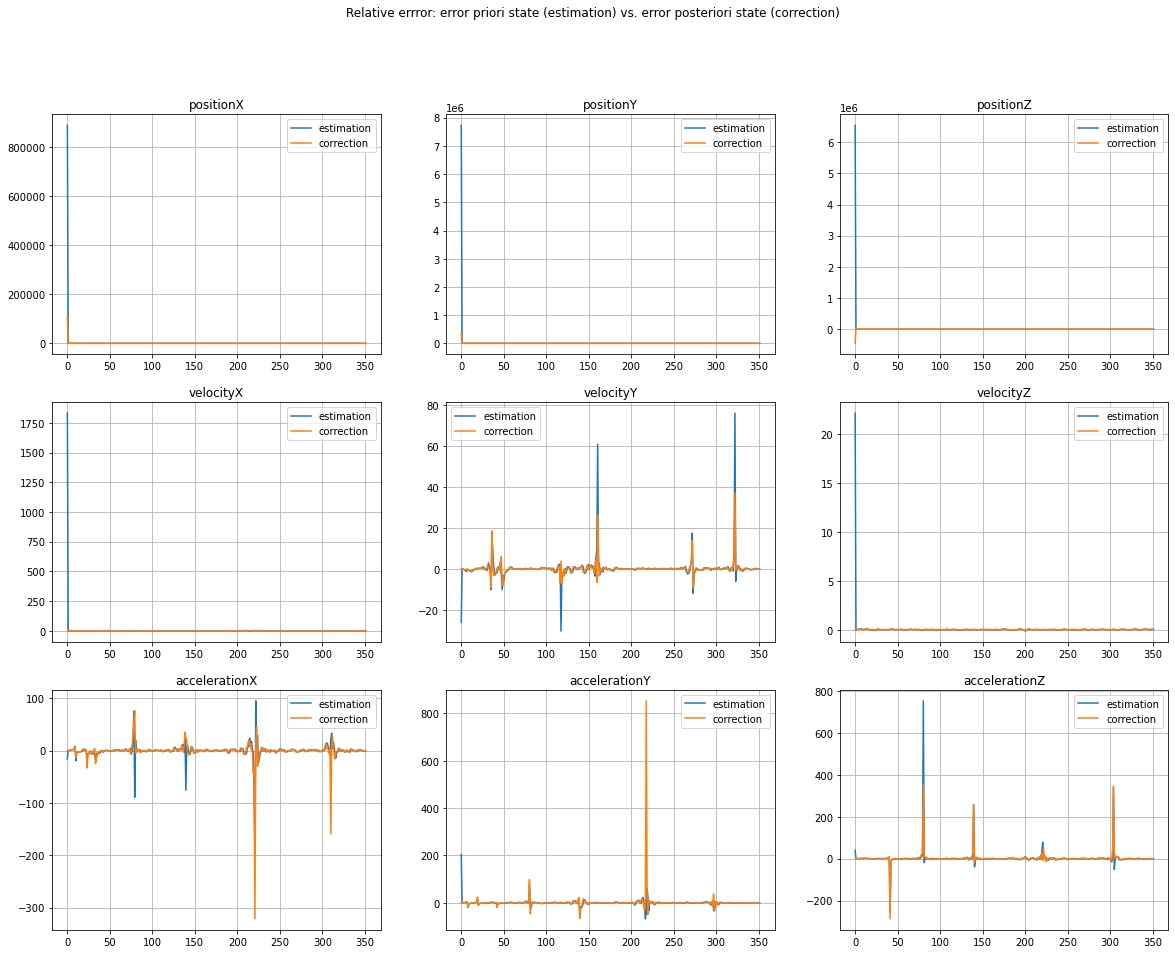

In [295]:
## Error estimación a priori vs estimación a posteriori
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(3, 3, figsize=(20,15))
fig.suptitle('Relative errror: error priori state (estimation) vs. error posteriori state (correction)')

for i in range(len(axs)):
    for j in range(len(axs[i])):
        axs[i,j].plot(x_scale, (x_priori[:,3*i+j] - X[:,3*i+j]) / (X[:,3*i+j]+0.0001) )
        axs[i,j].plot(x_scale, (x_posteriori[:,3*i+j] - X[:,3*i+j]) / (X[:,3*i+j]+0.0001) )
        axs[i,j].legend(["estimation", "correction"], loc='best')
        axs[i,j].grid()
        title = ''
        if i == 0:
            title = 'position'
        elif i == 1:
            title = 'velocity'
        elif i == 2:
            title = 'acceleration'
        if j == 0:
            title += 'X'
        elif j == 1:
            title += 'Y'
        elif j == 2:
            title += 'Z'
        
        axs[i,j].set_title(title)

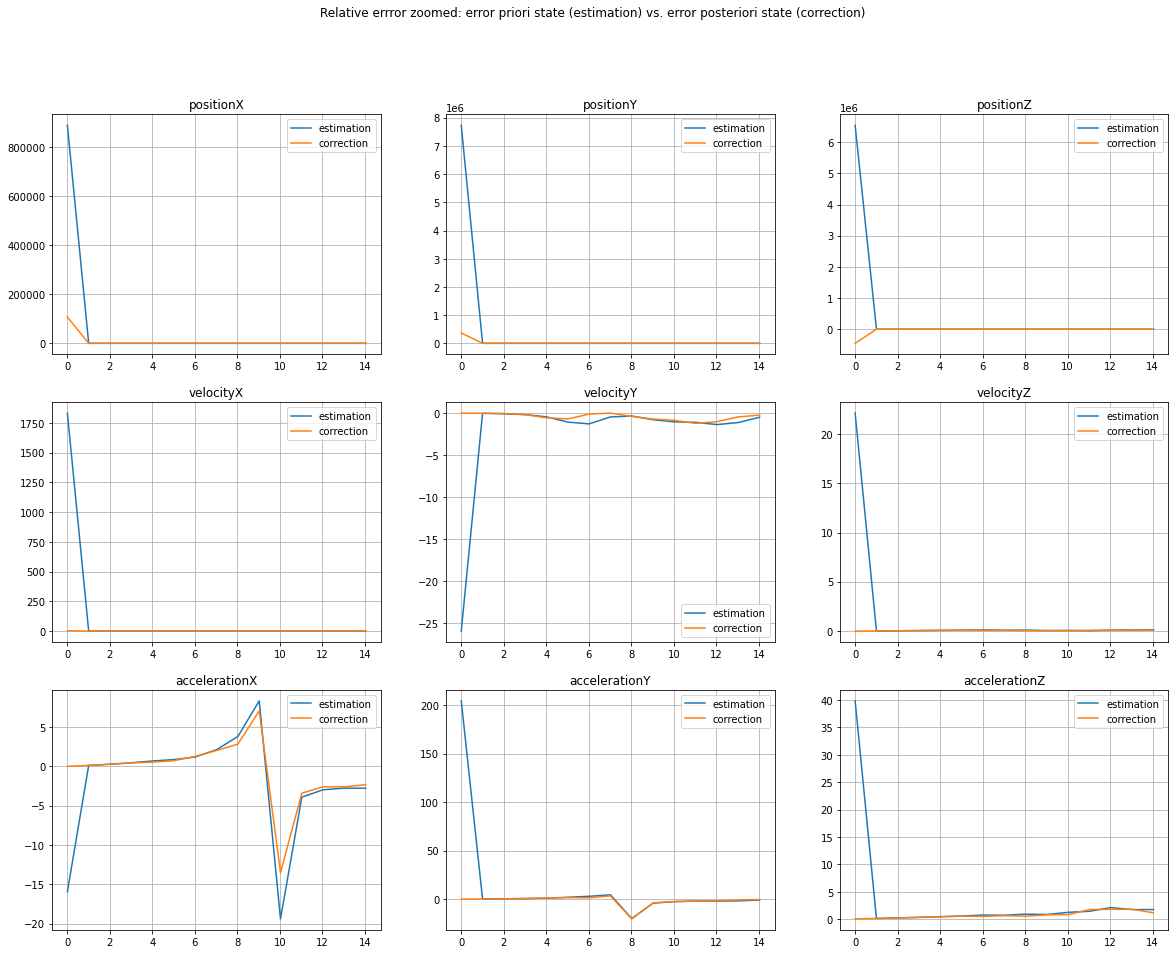

In [296]:
## (Zoomed) Error estimación a priori vs estimación a posteriori
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(3, 3, figsize=(20,15))
fig.suptitle('Relative errror zoomed: error priori state (estimation) vs. error posteriori state (correction)')

for i in range(len(axs)):
    for j in range(len(axs[i])):
        axs[i,j].plot(x_scale[:15], (x_priori[:15,3*i+j] - X[:15,3*i+j]) / (X[:15,3*i+j]+0.0001) )
        axs[i,j].plot(x_scale[:15], (x_posteriori[:15,3*i+j] - X[:15,3*i+j]) / (X[:15,3*i+j]+0.0001) )
        axs[i,j].legend(["estimation", "correction"], loc='best')
        axs[i,j].grid()
        title = ''
        if i == 0:
            title = 'position'
        elif i == 1:
            title = 'velocity'
        elif i == 2:
            title = 'acceleration'
        if j == 0:
            title += 'X'
        elif j == 1:
            title += 'Y'
        elif j == 2:
            title += 'Z'
        
        axs[i,j].set_title(title)

#### Conlusión
Como es de esperarse, al principio, el error relativo es los instantes iniciales depende mucho de las condiciones iniciales. Una vez que el sistema se estabiliza el error relativo de una y otra medición tienden a cero. Esto sucede gracias a la matriz de ganancia K. En los momentos iniciales, como la estimación es mala, la matriz P tendrá valores grandes. Dichos valores impactan en un incremento de la matriz K que hace que se le de mucha más importancia a las nuevas estimaciones, lo cual lleva rápidamente al sistema a corregirse.

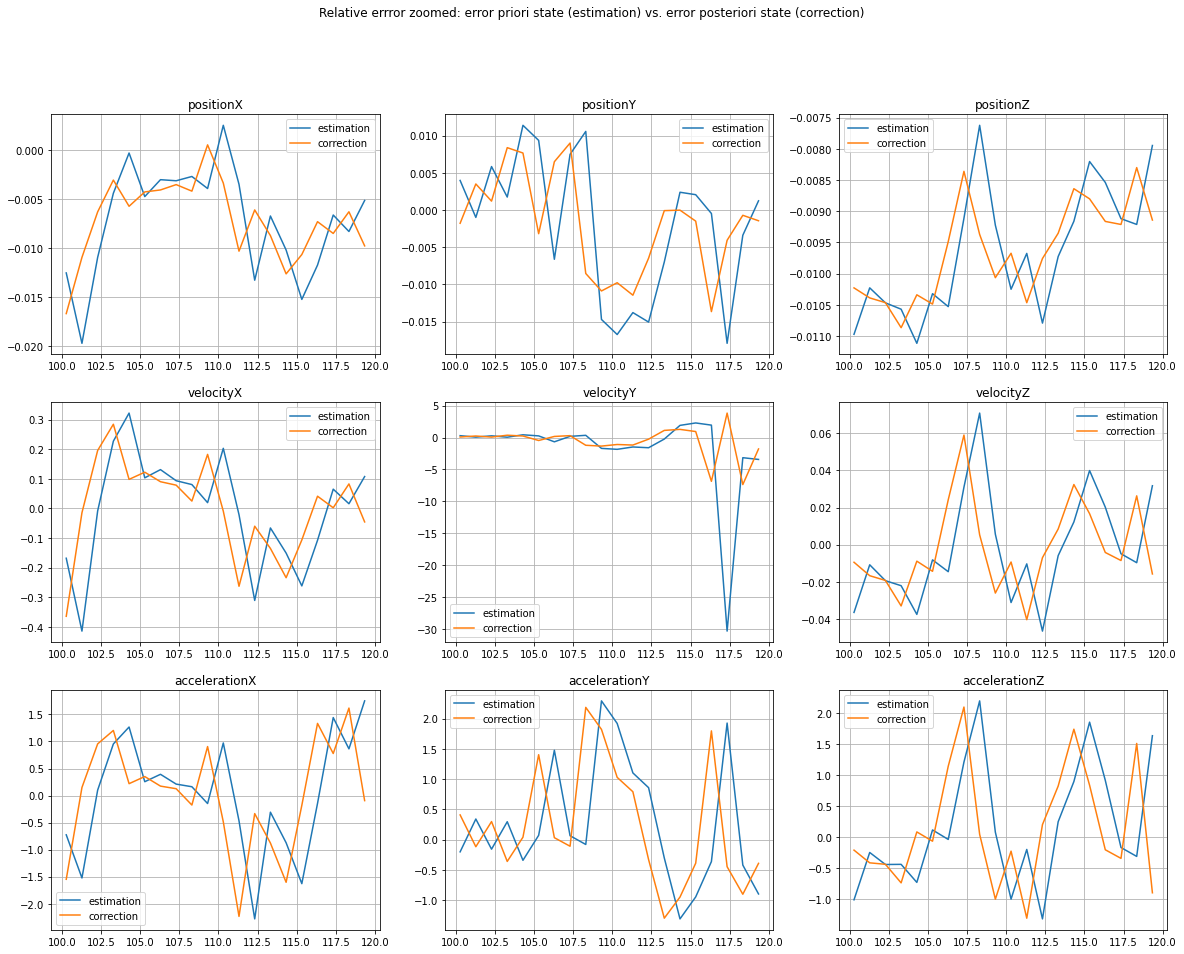

In [297]:
## (Zoomed 2) Error estimación a priori vs estimación a posteriori
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(3, 3, figsize=(20,15))
fig.suptitle('Relative errror zoomed: error priori state (estimation) vs. error posteriori state (correction)')

for i in range(len(axs)):
    for j in range(len(axs[i])):
        axs[i,j].plot(x_scale[100:120], (x_priori[100:120,3*i+j] - X[100:120,3*i+j]) / (X[100:120,3*i+j]+0.0001) )
        axs[i,j].plot(x_scale[100:120], (x_posteriori[100:120,3*i+j] - X[100:120,3*i+j]) / (X[100:120,3*i+j]+0.0001) )
        axs[i,j].legend(["estimation", "correction"], loc='best')
        axs[i,j].grid()
        title = ''
        if i == 0:
            title = 'position'
        elif i == 1:
            title = 'velocity'
        elif i == 2:
            title = 'acceleration'
        if j == 0:
            title += 'X'
        elif j == 1:
            title += 'Y'
        elif j == 2:
            title += 'Z'
        
        axs[i,j].set_title(title)

#### Conclusión
Al igual que en el análisis de las variables de estado, puede verse que las gráficas correspondientes al error relativo de la estimación a priori están decaladas en el tiempo respecto al error relativo de la estimación a posteriori. Esto puede comprobarse en las gráficas de la velocidad y en las gráficas de la aceleración. Tiene sentido que así sea ya que, al no tener información directa del sensor acerca de estas variables, serán una estimación a lo largo de todo instante de tiempo k y es lógico que la estimación en el instante k tome un valor muy similar a la estimación en el instante k-1 si el error en ese instante ha sido pequeño.

Text(0.5, 1.0, 'Mean squared error')

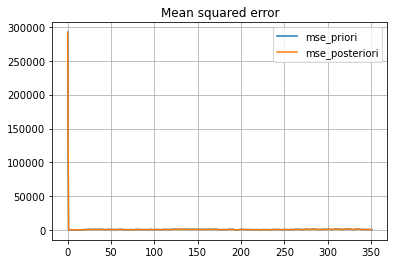

In [298]:
## Error cuadrático medio del estado
x_scale = np.linspace(0, n_samples, num=n_samples)

mse_priori = np.square(x_priori - X).mean(axis=1)
mse_posteriori = np.square(x_posteriori - X).mean(axis=1)

plt.plot(x_scale, mse_priori, mse_priori)
plt.legend(['mse_priori', 'mse_posteriori'])
plt.grid()
plt.title('Mean squared error')

Text(0.5, 1.0, 'Mean squared error zoomed')

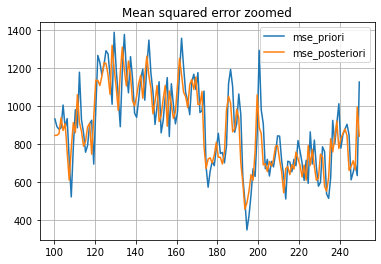

In [299]:
## Error cuadrático medio del estado (zoom)
x_scale = np.linspace(0, n_samples, num=n_samples)

mse_priori = np.square(x_priori - X).mean(axis=1)
mse_posteriori = np.square(x_posteriori - X).mean(axis=1)

plt.plot(x_scale[100:250], mse_priori[100:250])
plt.plot(x_scale[100:250], mse_posteriori[100:250])
plt.legend(['mse_priori', 'mse_posteriori'])
plt.grid()
plt.title('Mean squared error zoomed')

#### Conlusión
Como ha podido verse, conforme se pasa la dinámica inicial del sistema, la estimación a priori y la estimación a posteriori siguen el mismo patrón de evolución en todo instante. Solamente mirando los gráficos del error no se podrían sacar conclusiones para saber qué estimación es mejor. Para ello se debe analizar la matriz de covarianza P, que nos da intrínsecamente una medida de los errores.

### Comparación trazas de la matriz $P_{k|k-1}$ y $P_{k|k}$

In [300]:
## Trazas matriz P
tr_p_priori_gauss_pos = np.trace(P_priori, axis1=1, axis2=2)
tr_p_posteriori_gauss_pos = np.trace(P_posteriori, axis1=1, axis2=2)

Text(0.5, 1.0, 'Error: priori estimation vs. posteriori estimation')

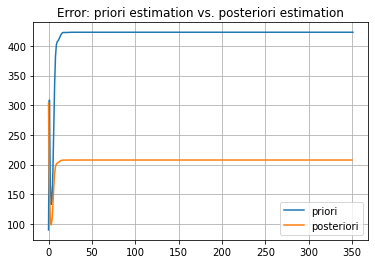

In [301]:
## Error
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, ax = plt.plot(x_scale, tr_p_priori_gauss_pos, tr_p_posteriori_gauss_pos)
plt.legend(["priori", "posteriori"], loc='best')
plt.grid()
plt.title("Error: priori estimation vs. posteriori estimation")

#### Conclusión
Se puede observar que el error de estimación a posteriori filtrado y corregido es menor que el error de estimación a priori en todo momento. Se concluye así que la mejor estimación es la estimación a posteriori. 

### Comparación de $y_{k}$ e $y_{k|k-1}$

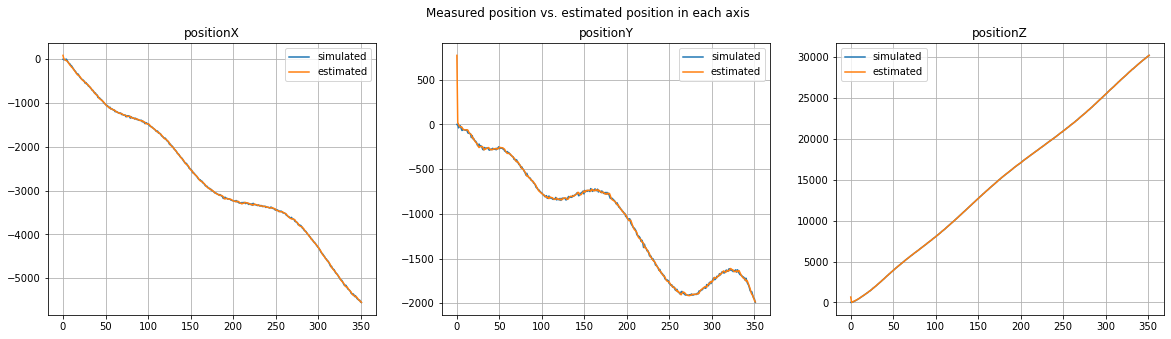

In [302]:
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(1, 3, figsize=(20,5))

fig.suptitle('Measured position vs. estimated position in each axis')

for i in range(len(axs)):
    axs[i].plot(x_scale[:], y[:,i])
    axs[i].plot(x_scale[:], y_priori[:,i] )
    axs[i].legend(["simulated", "estimated"], loc='best')
    axs[i].grid()
    title = 'position'
    if i == 0:
        title += 'X'
    elif i == 1:
        title += 'Y'
    elif i == 2:
        title += 'Z'
    
    axs[i].set_title(title)

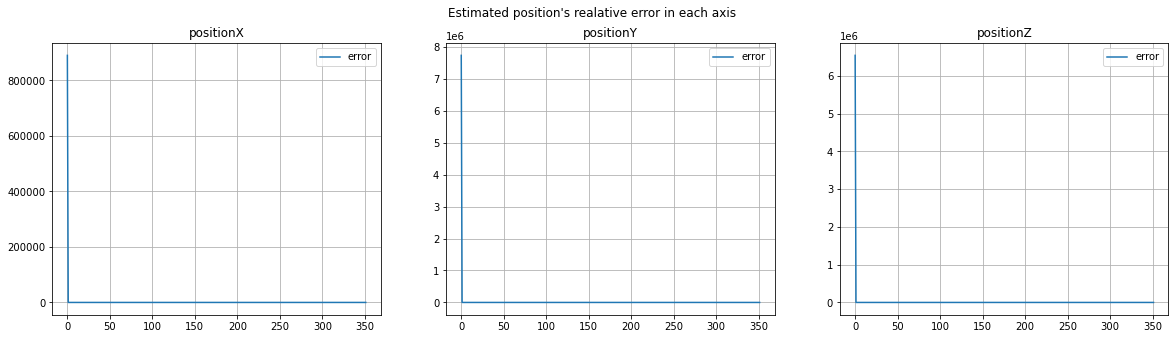

In [303]:
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(1, 3, figsize=(20,5))

fig.suptitle("Estimated position's realative error in each axis")

err_y_priori = np.abs(y_priori - y)/(y + 0.0001)

for i in range(len(axs)):
    axs[i].plot(x_scale[:], err_y_priori[:,i])
    axs[i].legend(["error"], loc='best')
    axs[i].grid()
    title = 'position'
    if i == 0:
        title += 'X'
    elif i == 1:
        title += 'Y'
    elif i == 2:
        title += 'Z'
    
    axs[i].set_title(title)

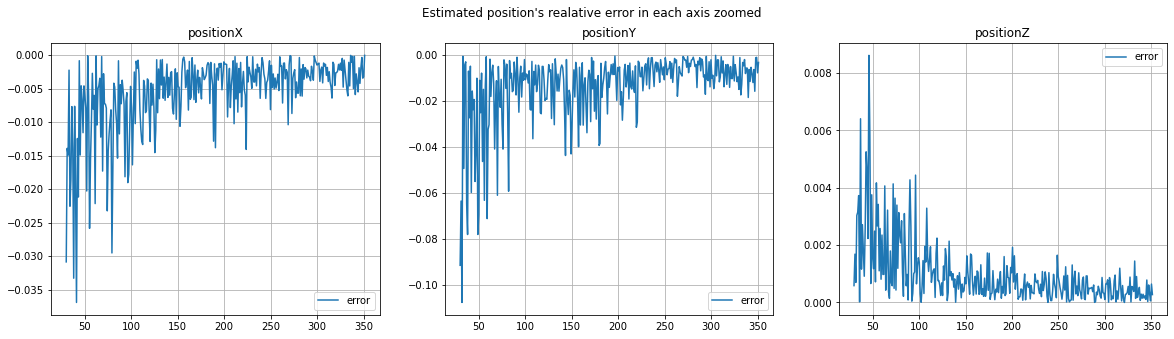

In [304]:
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(1, 3, figsize=(20,5))

fig.suptitle("Estimated position's realative error in each axis zoomed")

err_y_priori = np.abs(y_priori - y)/(y + 0.0001)

for i in range(len(axs)):
    axs[i].plot(x_scale[30:], err_y_priori[30:,i])
    axs[i].legend(["error"], loc='best')
    axs[i].grid()
    title = 'position'
    if i == 0:
        title += 'X'
    elif i == 1:
        title += 'Y'
    elif i == 2:
        title += 'Z'
    
    axs[i].set_title(title)

#### Conlusión
Conforme pasa el tiempo y el movimiento se estabiliza la posisión estimada tiene a acercarse mucho a la posición real.

## 2 - Midiendo solamente la posición, con ruido uniforme

In [305]:
## Iteración filtro de Kalman
x_priori_u = [x_priori_0]
y_u = [np.zeros((mc,1))]
y_priori_u = [C.dot(x_priori_0)]
P_priori_u = [P_priori_0]
x_posteriori_u = [x_posteriori_0]
P_posteriori_u = [P_posteriori_0]

desv_u = 10
## amplitude = b-a
## desv = (b-a) / 12**0.5 => amplitude = desv * 12**0.5
amplitude_u = desv_u * (12**0.5)
a_u = - amplitude_u/2
b_u = amplitude_u/2

for k in range(len(position)-1):
    ## Estimación a priori - predicción
    x_priori_k = A.dot(x_posteriori_u[-1])
    y_priori_k = C.dot(x_priori_k)
    P_priori_k = A.dot(P_posteriori_u[-1]).dot(A.T) + Q
    ## Estimación a posteriori - corrección
    # ruido blanco de medicion (uno para cada posición en ppio.)
    w_k = np.random.uniform(a_u, b_u, (3,1))
    R_k = R
    K_k = P_priori_k.dot(C.T).dot(np.linalg.inv(R_k + C.dot(P_priori_k).dot(C.T)))
    # valores de estado reales en instante k
    x_k = np.concatenate((position[k].reshape((3,1)), velocity[k].reshape((3,1)), acceleration[k].reshape((3,1))), axis=0)
    y_k = C.dot(x_k) + w_k
    x_posteriori_k = x_priori_k + K_k.dot(y_k - C.dot(x_priori_k))
    P_posteriori_k = (np.identity(9) - K_k.dot(C)).dot(P_priori_k)

    x_priori_u.append(x_priori_k)
    y_priori_u.append(y_priori_k)
    P_priori_u.append(P_priori_k)
    x_posteriori_u.append(x_posteriori_k)
    P_posteriori_u.append(P_posteriori_k)
    y_u.append(y_k)

# lists as numpy arrays
x_priori_u = np.array(x_priori_u).squeeze()
y_priori_u = np.array(y_priori_u).squeeze()
P_priori_u = np.array(P_priori_u)
x_posteriori_u = np.array(x_posteriori_u).squeeze()
P_posteriori_u = np.array(P_posteriori_u)
y_u = np.array(y_u).squeeze()

### Análisis del ruido

Text(0.5, 1.0, 'position Z')

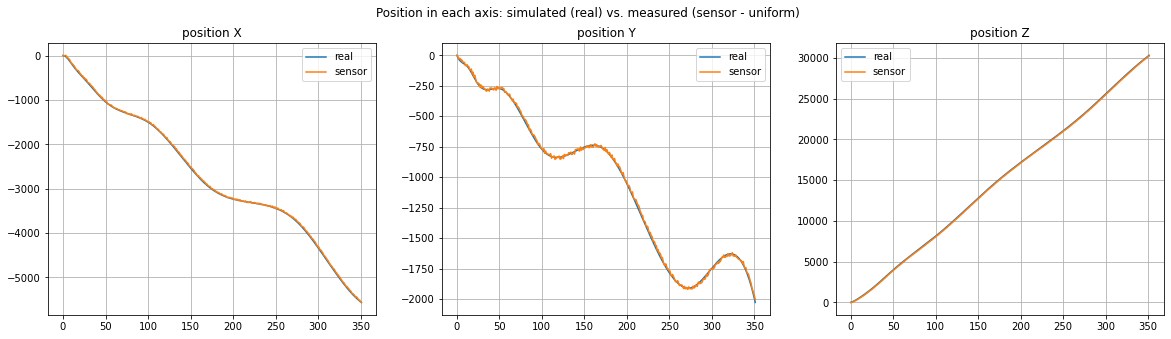

In [306]:
## Comparación señal simulada real vs señal medida con ruido uniforme
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle('Position in each axis: simulated (real) vs. measured (sensor - uniform)')

axs[0].plot(x_scale, position[:,0])
axs[0].plot(x_scale, y_u[:,0])
axs[0].legend(["real", "sensor"], loc='best')
axs[0].grid()
axs[0].set_title("position X")

axs[1].plot(x_scale, position[:,1], label='pos_y real')
axs[1].plot(x_scale, y_u[:,1], label='pos_y sensor')
axs[1].legend(["real", "sensor"], loc='best')
axs[1].grid()
axs[1].set_title("position Y")

axs[2].plot(x_scale, position[:,2], label='pos_z real')
axs[2].plot(x_scale, y_u[:,2], label='pos_z sensor')
axs[2].legend(["real", "sensor"], loc='best')
axs[2].grid()
axs[2].set_title("position Z")

Text(0.5, 1.0, 'error Z')

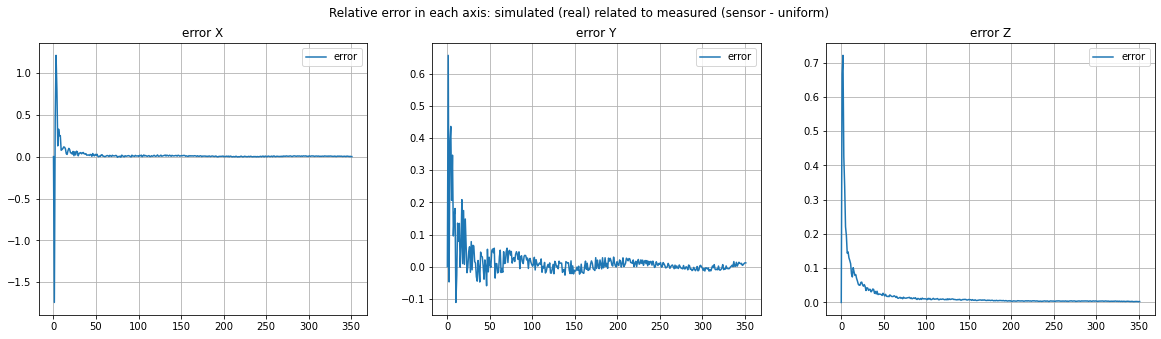

In [307]:
## Error relativo señal simulada real vs señal medida con ruido uniforme
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle('Relative error in each axis: simulated (real) related to measured (sensor - uniform)')

axs[0].plot(x_scale, (position[:,0]-y_u[:,0])/(position[:,0]+0.00001))
axs[0].legend(["error"], loc='best')
axs[0].grid()
axs[0].set_title("error X")

axs[1].plot(x_scale, (position[:,1]-y_u[:,1])/(position[:,1]+0.00001))
axs[1].legend(["error"], loc='best')
axs[1].grid()
axs[1].set_title("error Y")

axs[2].plot(x_scale, (position[:,2]-y_u[:,2])/(position[:,2]+0.00001))
axs[2].legend(["error"], loc='best')
axs[2].grid()
axs[2].set_title("error Z")

In [308]:
max_error = np.max((position[:,0]-y_u[:,0])/(position[:,0]+0.0001))
mean_error = np.mean((position[:,0]-y_u[:,0])/(position[:,0]+0.0001))
print(max_error)
print(mean_error)

1.2093956638791867
0.015122049691541267


#### Conclusión
Como es de esperarse, dado que el ruido uniforme tiene media cero, la media del error también se aproxima mucho a dicho valor.
En los periodos iniciales el error es muy grande debido a la diferencia en las condiciones iniciales. A medida que pasa el tiempo el filtro hace su efecto.

Text(0.5, 1.0, 'error Z')

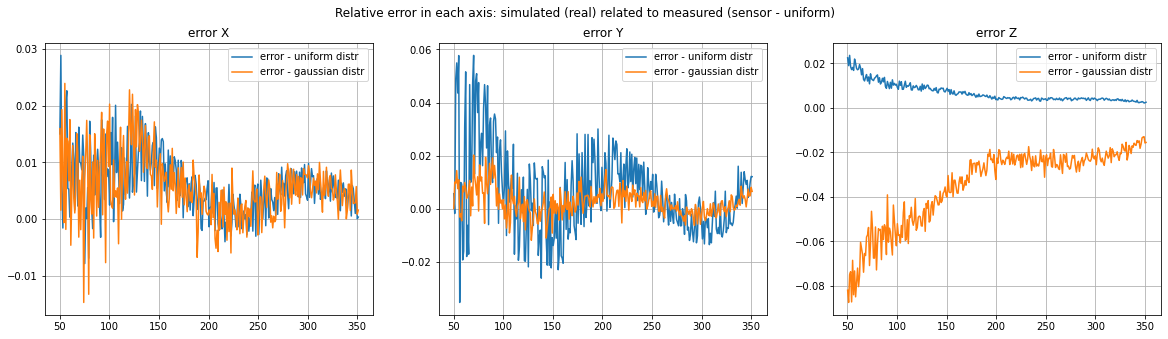

In [309]:
## Error relativo señal medida con ruido gausiano vs señal medida con ruido uniforme
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle('Relative error in each axis: simulated (real) related to measured (sensor - uniform)')

axs[0].plot(x_scale[50:], (position[50:,0]-y_u[50:,0])/(position[50:,0]+0.00001))
axs[0].plot(x_scale[50:], (position[50:,0]-y[50:,0])/(position[50:,0]+0.00001))
axs[0].legend(["error - uniform distr", "error - gaussian distr"], loc='best')
axs[0].grid()
axs[0].set_title("error X")

axs[1].plot(x_scale[50:], (position[50:,1]-y_u[50:,1])/(position[50:,1]+0.00001))
axs[1].plot(x_scale[50:], (position[50:,1]-y[50:,1])/(position[50:,0]+0.00001))
axs[1].legend(["error - uniform distr", "error - gaussian distr"], loc='best')
axs[1].grid()
axs[1].set_title("error Y")

axs[2].plot(x_scale[50:], (position[50:,2]-y_u[50:,2])/(position[50:,2]+0.00001))
axs[2].plot(x_scale[50:], (position[50:,2]-y[50:,2])/(position[50:,0]+0.00001))
axs[2].legend(["error - uniform distr", "error - gaussian distr"], loc='best')
axs[2].grid()
axs[2].set_title("error Z")

#### Conlusión
Puede verse que la perturbación generada por el ruido uniforme es mayor que la generada por el ruido gaussiano.

### Comparación entre $\hat{x}_{k|k}$, $\hat{x}_{k|k-1}$ y $x_k$

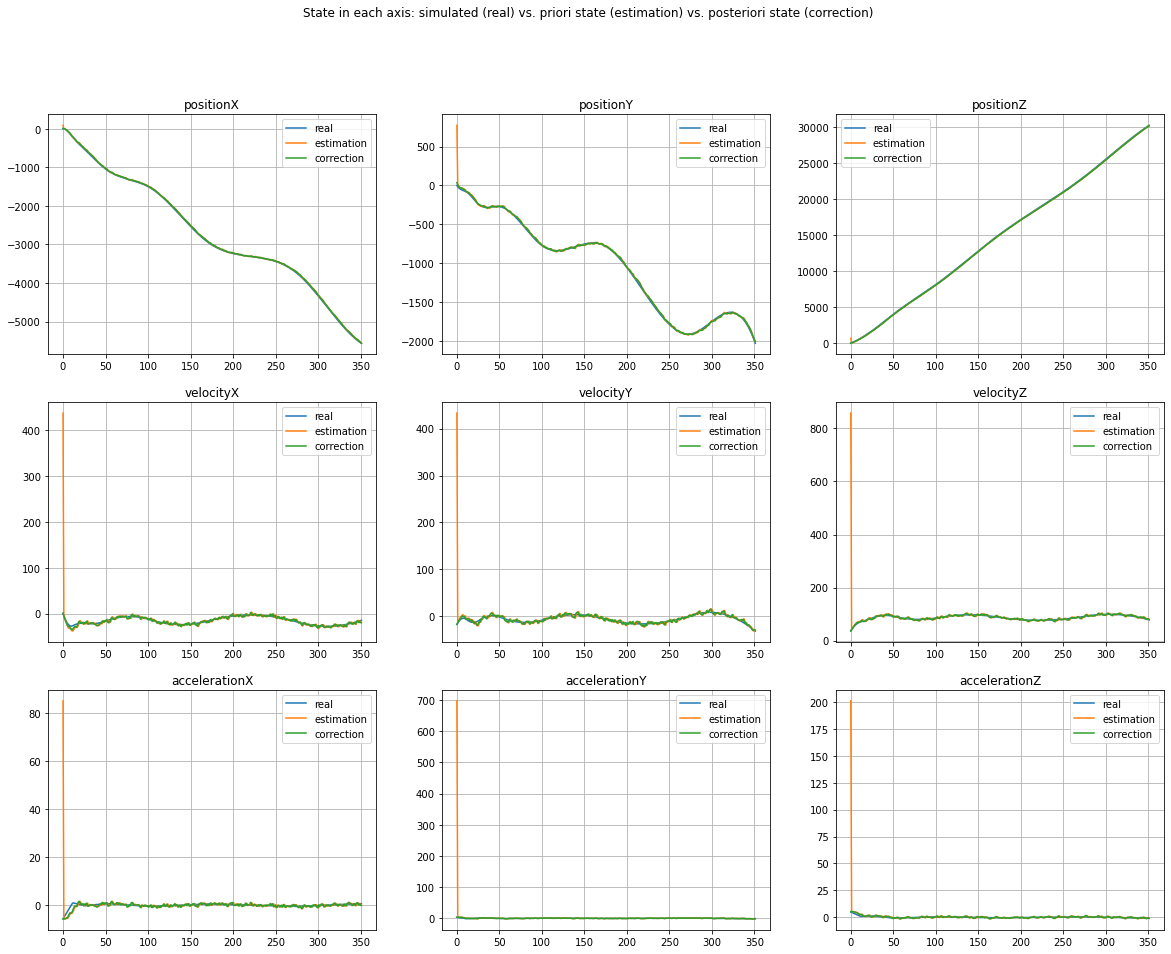

In [310]:
## Comparación señal simulada real vs señal medida con ruido uniforme vs. posición estimada vs. posición corregida
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(3, 3, figsize=(20,15))
fig.suptitle('State in each axis: simulated (real) vs. priori state (estimation) vs. posteriori state (correction)')

for i in range(len(axs)):
    for j in range(len(axs[i])):
        axs[i,j].plot(x_scale, X[:,3*i+j])
        axs[i,j].plot(x_scale, x_priori_u[:,3*i+j])
        axs[i,j].plot(x_scale, x_posteriori_u[:,3*i+j])
        axs[i,j].legend(["real", "estimation", "correction"], loc='best')
        axs[i,j].grid()
        title = ''
        if i == 0:
            title = 'position'
        elif i == 1:
            title = 'velocity'
        elif i == 2:
            title = 'acceleration'
        if j == 0:
            title += 'X'
        elif j == 1:
            title += 'Y'
        elif j == 2:
            title += 'Z'
        
        axs[i,j].set_title(title)

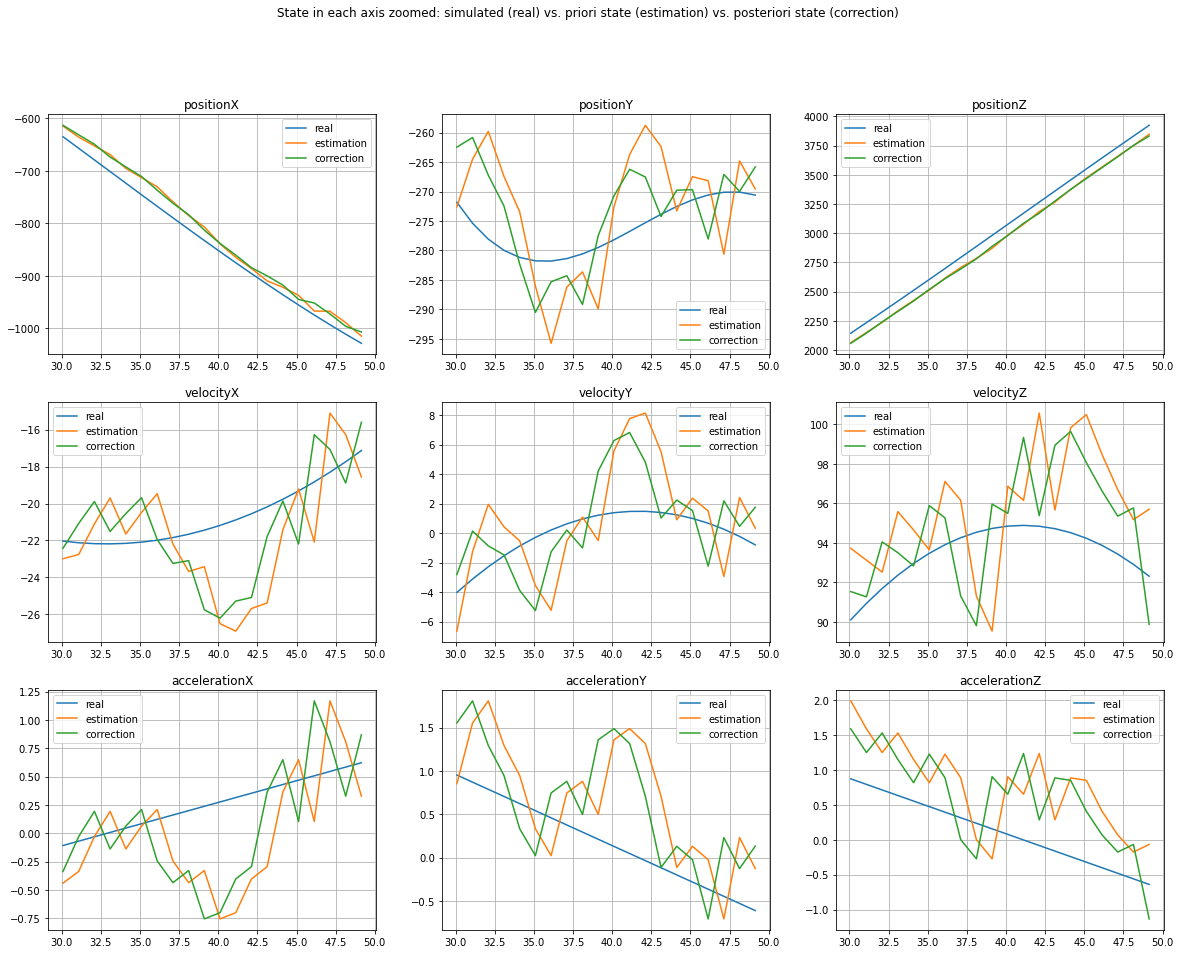

In [311]:
## (Zoom) Comparación señal simulada real vs señal medida con ruido uniforme vs. posición estimada vs. posición corregida
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(3, 3, figsize=(20,15))
fig.suptitle('State in each axis zoomed: simulated (real) vs. priori state (estimation) vs. posteriori state (correction)')

for i in range(len(axs)):
    for j in range(len(axs[i])):
        axs[i,j].plot(x_scale[30:50], X[30:50,3*i+j])
        axs[i,j].plot(x_scale[30:50], x_priori_u[30:50,3*i+j])
        axs[i,j].plot(x_scale[30:50], x_posteriori_u[30:50,3*i+j])
        axs[i,j].legend(["real", "estimation", "correction"], loc='best')
        axs[i,j].grid()
        title = ''
        if i == 0:
            title = 'position'
        elif i == 1:
            title = 'velocity'
        elif i == 2:
            title = 'acceleration'
        if j == 0:
            title += 'X'
        elif j == 1:
            title += 'Y'
        elif j == 2:
            title += 'Z'
        
        axs[i,j].set_title(title)

#### Conclusión
En las gráficas, la evolución de la estimación a priori (legend: estimation) está decalada (atrasada) en el tiempo respecto a la evolución de la estimación a posteriori (legend: correction). Esto puede verse sobre todo en las gráficas de la velocidad y en las gráficas de la aceleración. Tiene sentido que así sea para estas variables ya que, al no tener información directa de algún sensor acerca de estas variables, serán una estimación a lo largo de todo instante de tiempo k y es lógico que la estimación en el instante k tome un valor muy similar a la estimación corregida en el instante k-1 si el error en ese instante ha sido pequeño.

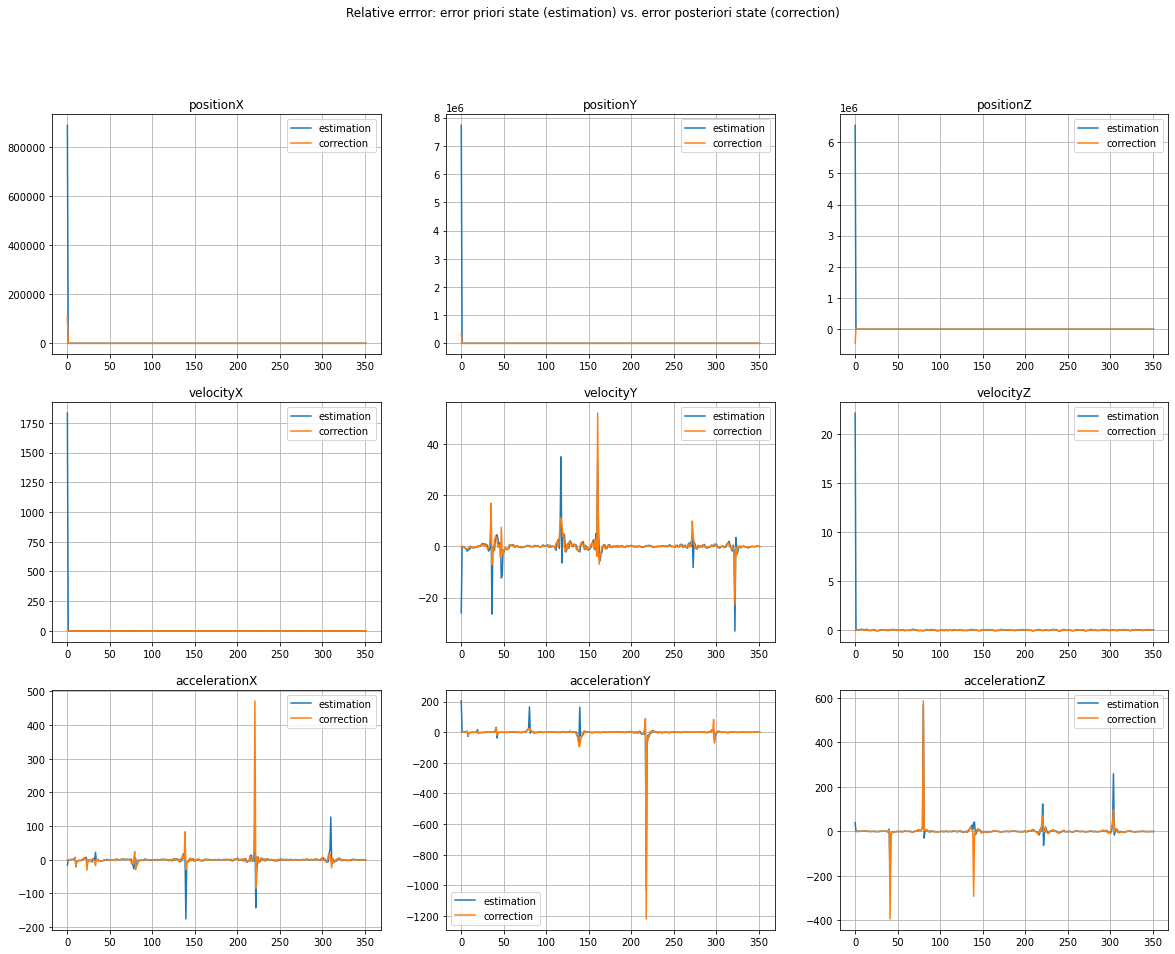

In [312]:
## Error estimación a priori vs estimación a posteriori
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(3, 3, figsize=(20,15))
fig.suptitle('Relative errror: error priori state (estimation) vs. error posteriori state (correction)')

for i in range(len(axs)):
    for j in range(len(axs[i])):
        axs[i,j].plot(x_scale, (x_priori_u[:,3*i+j] - X[:,3*i+j]) / (X[:,3*i+j]+0.0001) )
        axs[i,j].plot(x_scale, (x_posteriori_u[:,3*i+j] - X[:,3*i+j]) / (X[:,3*i+j]+0.0001) )
        axs[i,j].legend(["estimation", "correction"], loc='best')
        axs[i,j].grid()
        title = ''
        if i == 0:
            title = 'position'
        elif i == 1:
            title = 'velocity'
        elif i == 2:
            title = 'acceleration'
        if j == 0:
            title += 'X'
        elif j == 1:
            title += 'Y'
        elif j == 2:
            title += 'Z'
        
        axs[i,j].set_title(title)

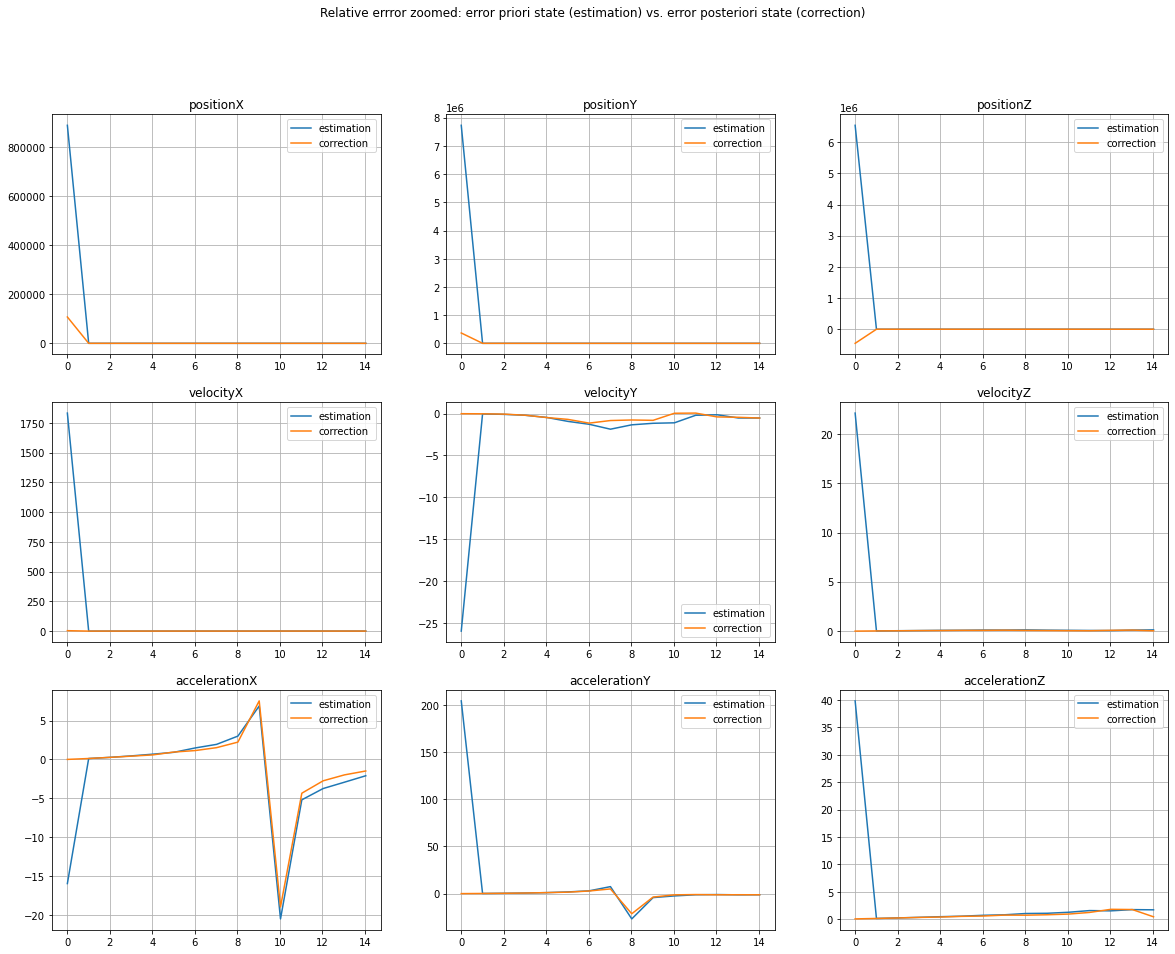

In [313]:
## (Zoomed) Error estimación a priori vs estimación a posteriori
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(3, 3, figsize=(20,15))
fig.suptitle('Relative errror zoomed: error priori state (estimation) vs. error posteriori state (correction)')

for i in range(len(axs)):
    for j in range(len(axs[i])):
        axs[i,j].plot(x_scale[:15], (x_priori_u[:15,3*i+j] - X[:15,3*i+j]) / (X[:15,3*i+j]+0.0001) )
        axs[i,j].plot(x_scale[:15], (x_posteriori_u[:15,3*i+j] - X[:15,3*i+j]) / (X[:15,3*i+j]+0.0001) )
        axs[i,j].legend(["estimation", "correction"], loc='best')
        axs[i,j].grid()
        title = ''
        if i == 0:
            title = 'position'
        elif i == 1:
            title = 'velocity'
        elif i == 2:
            title = 'acceleration'
        if j == 0:
            title += 'X'
        elif j == 1:
            title += 'Y'
        elif j == 2:
            title += 'Z'
        
        axs[i,j].set_title(title)

#### Conlusión
Como es de esperarse, al principio, el error relativo es los instantes iniciales depende mucho de las condiciones iniciales. Una vez que el sistema se estabiliza el error relativo de una y otra medición tienden a cero. Esto sucede gracias a la matriz de ganancia K. En los momentos iniciales, como la estimación es mala, la matriz P tendrá valores grandes. Dichos valores impactan en un incremento de la matriz K que hace que se le de mucha más importancia a las nuevas estimaciones, lo cual lleva rápidamente al sistema a corregirse.

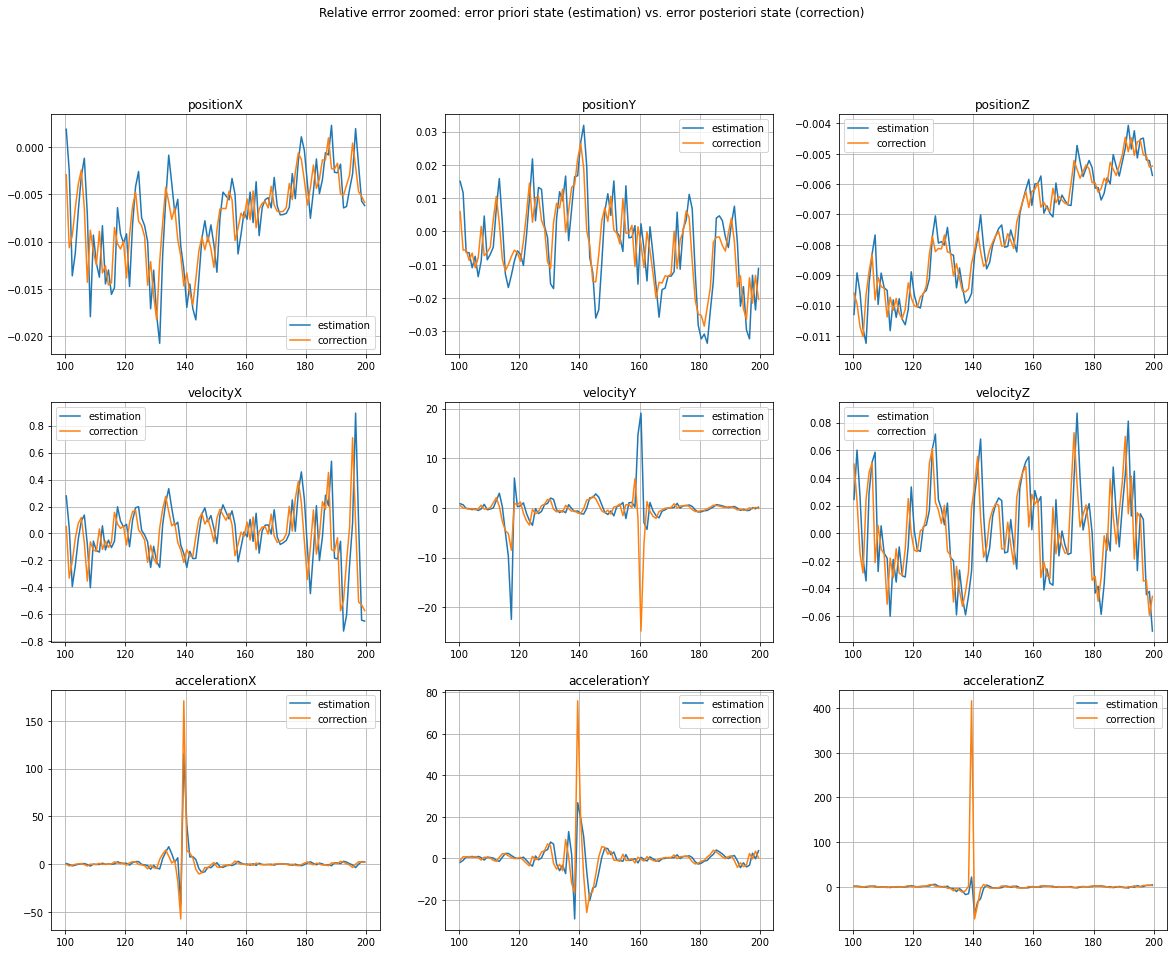

In [174]:
## (Zoomed 2) Error estimación a priori vs estimación a posteriori
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(3, 3, figsize=(20,15))
fig.suptitle('Relative errror zoomed: error priori state (estimation) vs. error posteriori state (correction)')

for i in range(len(axs)):
    for j in range(len(axs[i])):
        axs[i,j].plot(x_scale[100:200], (x_priori_u[100:200,3*i+j] - X[100:200,3*i+j]) / (X[100:200,3*i+j]+0.0001) )
        axs[i,j].plot(x_scale[100:200], (x_posteriori_u[100:200,3*i+j] - X[100:200,3*i+j]) / (X[100:200,3*i+j]+0.0001) )
        axs[i,j].legend(["estimation", "correction"], loc='best')
        axs[i,j].grid()
        title = ''
        if i == 0:
            title = 'position'
        elif i == 1:
            title = 'velocity'
        elif i == 2:
            title = 'acceleration'
        if j == 0:
            title += 'X'
        elif j == 1:
            title += 'Y'
        elif j == 2:
            title += 'Z'
        
        axs[i,j].set_title(title)

#### Conclusión
Al igual que en el análisis de las variables de estado, se ve que las gráficas correspondientes al error relativo de la estimación a priori están decaladas en el tiempo respecto al error relativo de la estimación a posteriori. Esto puede verse en las gráficas de la velocidad y en las gráficas de la aceleración. Tiene sentido que así sea ya que, al no tener información directa del sensor acerca de estas variables, serán una estimación a lo largo de todo instante de tiempo k y es lógico que la estimación en el instante k tome un valor muy similar a la estimación en el instante k-1 si el error en ese instante ha sido pequeño.

Text(0.5, 1.0, 'Mean squared error')

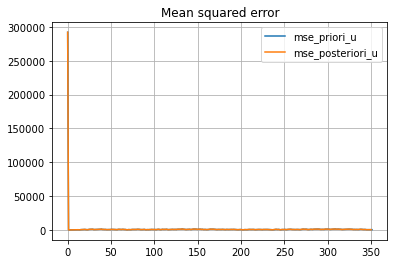

In [315]:
## Error cuadrático medio del estado
x_scale = np.linspace(0, n_samples, num=n_samples)

mse_priori_u = np.square(x_priori_u - X).mean(axis=1)
mse_posteriori_u = np.square(x_posteriori_u - X).mean(axis=1)

plt.plot(x_scale, mse_priori_u, mse_priori_u)
plt.legend(['mse_priori_u', 'mse_posteriori_u'])
plt.grid()
plt.title('Mean squared error')

Text(0.5, 1.0, 'Mean squared error zoomed')

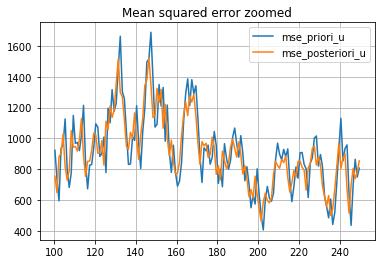

In [316]:
## Error cuadrático medio del estado (zoom)
x_scale = np.linspace(0, n_samples, num=n_samples)

mse_priori_u = np.square(x_priori_u - X).mean(axis=1)
mse_posteriori_u = np.square(x_posteriori_u - X).mean(axis=1)

plt.plot(x_scale[100:250], mse_priori_u[100:250])
plt.plot(x_scale[100:250], mse_posteriori_u[100:250])
plt.legend(['mse_priori_u', 'mse_posteriori_u'])
plt.grid()
plt.title('Mean squared error zoomed')

#### Conlusión
Como ha podido verse, conforme se pasa la dinámica inicial del sistema, la estimación a priori y la estimación a posteriori siguen el mismo patrón de evolución en todo instante. Solamente mirando los gráficos del error no se podrían sacar conclusiones para saber qué estimación es mejor. Para ello se debe analizar la matriz de covarianza P, que nos da intrínsecamente una medida de los errores.

Text(0.5, 1.0, 'mse etimations')

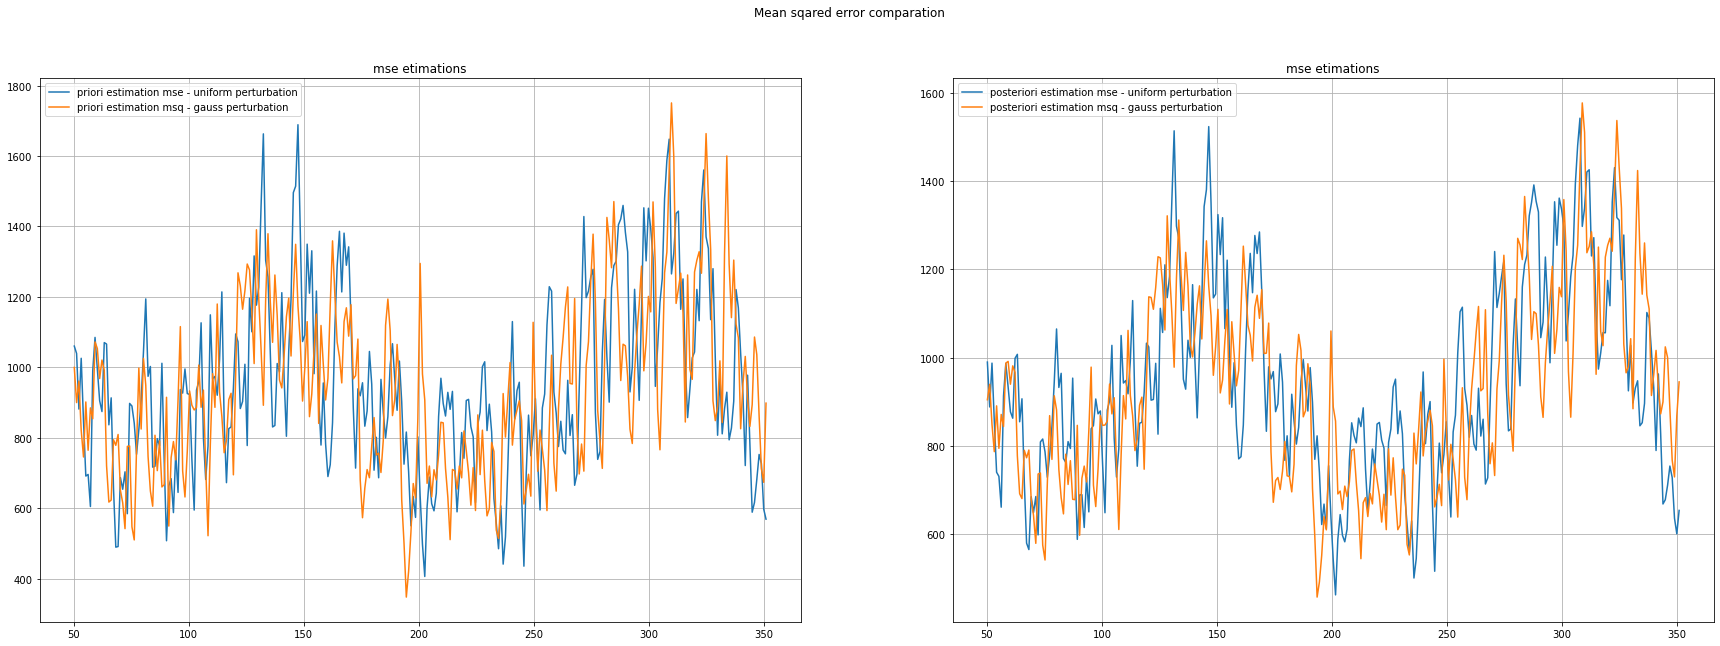

In [317]:
# Comparación de los errores cuadráticos medios.
## Error cuadrático medio del estado (zoom)
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(1, 2, figsize=(30,10))
fig.suptitle('Mean sqared error comparation')

axs[0].plot(x_scale[50:], mse_priori_u[50:] )
axs[0].plot(x_scale[50:], mse_priori[50:] )
axs[0].legend(["priori estimation mse - uniform perturbation", "priori estimation mse - gauss perturbation"], loc='best')
axs[0].grid()
axs[0].set_title("mse etimations")

axs[1].plot(x_scale[50:], mse_posteriori_u[50:] )
axs[1].plot(x_scale[50:], mse_posteriori[50:] )
axs[1].legend(["posteriori estimation mse - uniform perturbation", "posteriori estimation mse - gauss perturbation"], loc='best')
axs[1].grid()
axs[1].set_title("mse etimations")

#### Conlusión
Mirando el gráfico no puede decirse que un ruido uniforme afecta más o menos al sistema que un ruido gaussiano. Para un mejor análisis se deben comparar las trazas de las matrices P en uno y otro caso.

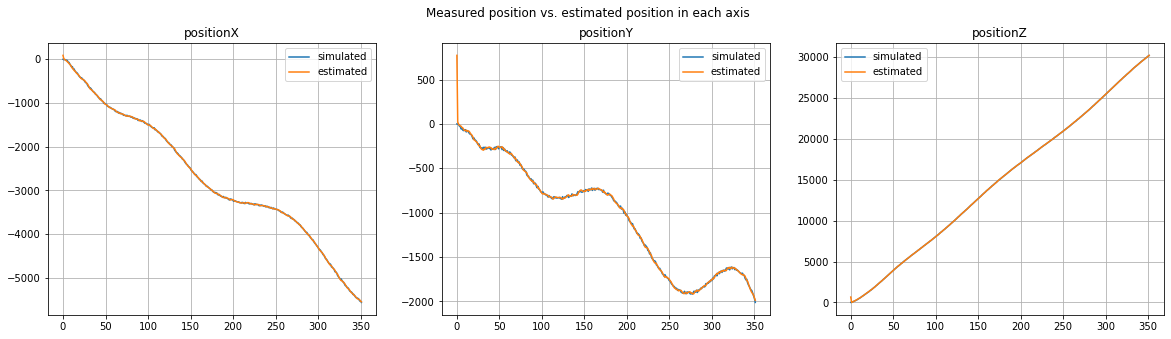

In [236]:
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(1, 3, figsize=(20,5))

fig.suptitle('Measured position vs. estimated position in each axis')

for i in range(len(axs)):
    axs[i].plot(x_scale[:], y_u[:,i])
    axs[i].plot(x_scale[:], y_priori_u[:,i] )
    axs[i].legend(["simulated", "estimated"], loc='best')
    axs[i].grid()
    title = 'position'
    if i == 0:
        title += 'X'
    elif i == 1:
        title += 'Y'
    elif i == 2:
        title += 'Z'
    
    axs[i].set_title(title)

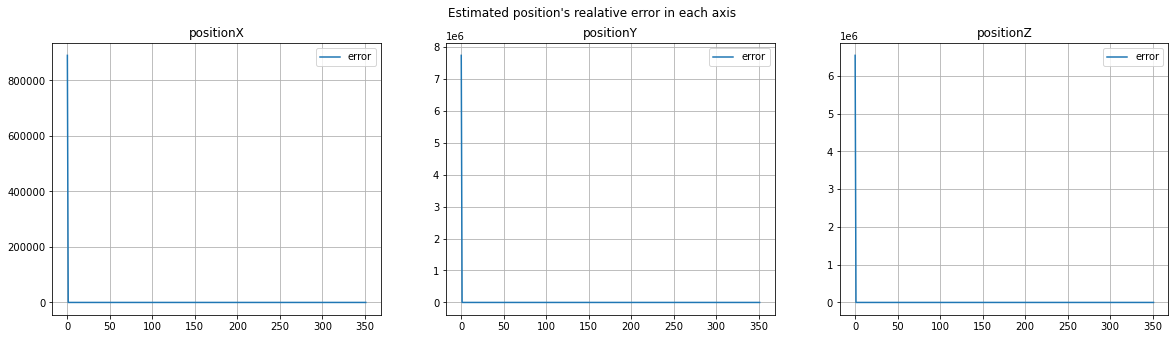

In [318]:
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(1, 3, figsize=(20,5))

fig.suptitle("Estimated position's realative error in each axis")

err_y_priori_u = (y_priori_u - y_u)/(y_u + 0.0001)

for i in range(len(axs)):
    axs[i].plot(x_scale[:], err_y_priori_u[:,i])
    axs[i].legend(["error"], loc='best')
    axs[i].grid()
    title = 'position'
    if i == 0:
        title += 'X'
    elif i == 1:
        title += 'Y'
    elif i == 2:
        title += 'Z'
    
    axs[i].set_title(title)

Text(0.5, 1.0, 'Error: priori estimation vs. posteriori estimation')

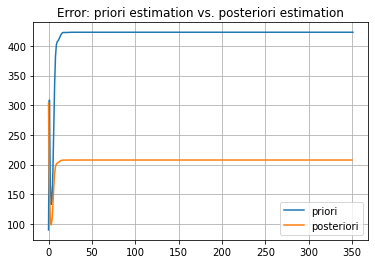

In [319]:
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(1, 3, figsize=(20,5))

fig.suptitle("Estimated position's realative error in each axis zoomed")

err_y_priori_u = np.abs(y_priori_u - y_u)/(y_u + 0.0001)

for i in range(len(axs)):
    axs[i].plot(x_scale[30:], err_y_priori_u[30:,i])
    axs[i].legend(["error"], loc='best')
    axs[i].grid()
    title = 'position'
    if i == 0:
        title += 'X'
    elif i == 1:
        title += 'Y'
    elif i == 2:
        title += 'Z'
    
    axs[i].set_title(title)

#### Conlusión
Conforme pasa el tiempo y el movimiento se estabiliza la posisión estimada tiene a acercarse mucho a la posición real.

### Comparación trazas de la matriz $P_{k|k-1}$ y $P_{k|k}$

In [188]:
## Trazas matriz P
tr_p_priori_u_pos = np.trace(P_priori_u, axis1=1, axis2=2)
tr_p_posteriori_u_pos = np.trace(P_posteriori_u, axis1=1, axis2=2)

### Comparación de $y_{k}$ e $y_{k|k-1}$

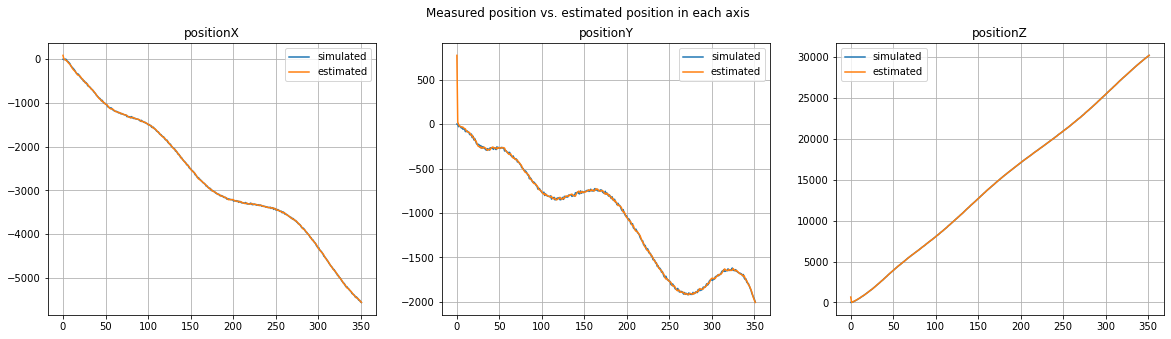

In [321]:
## Error
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, ax = plt.plot(x_scale, tr_p_priori_u_pos, tr_p_posteriori_u_pos)
plt.legend(["priori", "posteriori"], loc='best')
plt.grid()
plt.title("Error: priori estimation vs. posteriori estimation")

#### Conclusión
Al igual que con el anális anterior con perturbaciones gaussianas, se puede observar que el error de estimación a posteriori filtrado y corregido es menor que el error de estimación a priori en todo momento. Se concluye así que la mejor estimación es la estimación a posteriori. 

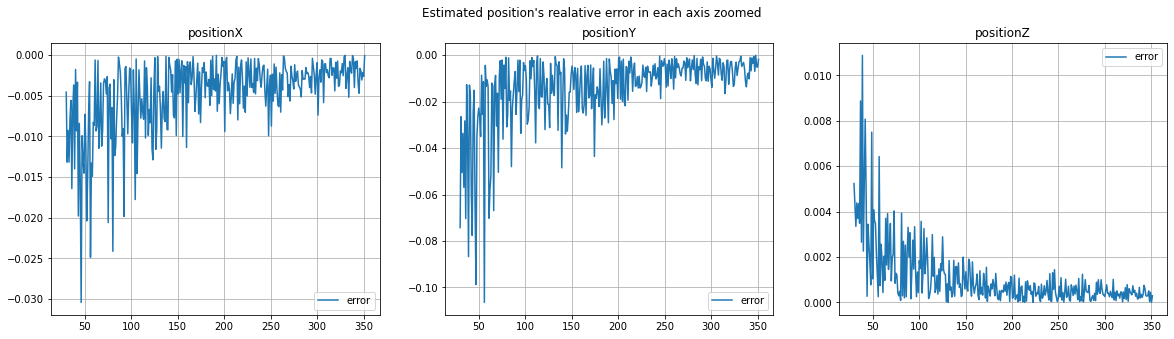

In [323]:
# Comparación de una y otra perturbación
## Error verdadero
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(1, 2, figsize=(30,10))
fig.suptitle('Error comparation')

axs[0].plot(x_scale, tr_p_priori_u_pos )
axs[0].plot(x_scale, tr_p_priori_gauss_pos )
axs[0].legend(["priori estimation error - uniform perturbation", "priori estimation error - gauss perturbation"], loc='best')
axs[0].grid()
axs[0].set_title("error priori etimations")

axs[1].plot(x_scale, tr_p_posteriori_u_pos )
axs[1].plot(x_scale, tr_p_posteriori_gauss_pos )
axs[1].legend(["posteriori estimation error - uniform perturbation", "posteriori estimation error - gauss perturbation"], loc='best')
axs[1].grid()
axs[1].set_title("error posteriori etimations")

#### Conlusión
Con las gráficas ilustradas no se puede decir que una perturbación afecta más al sistema que la otra. De hecho el impacto es bastante similiar. Se concluye que la aplicación del filtro de Kalman performa prácticamente de manera similar ante una perturbación con distribución uniforme que ante una perturbación con distribución normal.

## 3 - Midiendo posición y velocidad, con ruido gaussiano

In [326]:
## Ruido de medición
R = np.diag(np.array([10,10,10,0.2,0.2,0.2]))  

In [327]:
## Matriz de observación
C_pos = np.concatenate((np.identity(mc), np.zeros((mc,mc)), np.zeros((mc,mc))), axis=1)
C_vel = np.concatenate((np.zeros((mc,mc)), np.identity(mc), np.zeros((mc,mc))), axis=1)
C = np.concatenate((C_pos, C_vel), axis=0)

assert C.shape == (2*mc, nx)

In [328]:
## Iteración filtro de Kalman
x_priori_pv = [x_priori_0]
y_pv = [np.zeros((2*mc,1))]
y_priori_pv = [C.dot(x_priori_0)]
P_priori_pv = [P_priori_0]
#P_priori = [10*np.identity(nx)]
x_posteriori_pv = [x_posteriori_0]
P_posteriori_pv = [P_posteriori_0]


for k in range(len(position)-1):
    ## Estimación a priori - predicción
    x_priori_k = A.dot(x_posteriori_pv[-1])
    y_priori_k = C.dot(x_priori_k)
    P_priori_k = A.dot(P_posteriori_pv[-1]).dot(A.T) + Q
    ## Estimación a posteriori - corrección
    # ruido blanco de medicion
    wp_k = np.random.normal(0, 10, (3,1))
    wv_k = np.random.normal(0, 0.2, (3,1))
    R_k = R
    K_k = P_priori_k.dot(C.T).dot(np.linalg.inv(R_k + C.dot(P_priori_k).dot(C.T)))
    # valores de estado reales en instante k
    x_k = np.concatenate((position[k].reshape((3,1)), velocity[k].reshape((3,1)), acceleration[k].reshape((3,1))), axis=0)
    y_k = C.dot(x_k) + np.concatenate((wp_k, wv_k), axis=0)
    x_posteriori_k = x_priori_k + K_k.dot(y_k - C.dot(x_priori_k))
    P_posteriori_k = (np.identity(9) - K_k.dot(C)).dot(P_priori_k)

    x_priori_pv.append(x_priori_k)
    y_priori_pv.append(y_priori_k)
    P_priori_pv.append(P_priori_k)
    x_posteriori_pv.append(x_posteriori_k)
    P_posteriori_pv.append(P_posteriori_k)
    y_pv.append(y_k)

# lists as numpy arrays
x_priori_pv = np.array(x_priori_pv).squeeze()
y_priori_pv = np.array(y_priori_pv).squeeze()
P_priori_pv = np.array(P_priori_pv)
x_posteriori_pv = np.array(x_posteriori_pv).squeeze()
P_posteriori_pv = np.array(P_posteriori_pv)
y_pv = np.array(y_pv).squeeze()

### Comparación entre $\hat{x}_{k|k}$, $\hat{x}_{k|k-1}$ y $x_k$

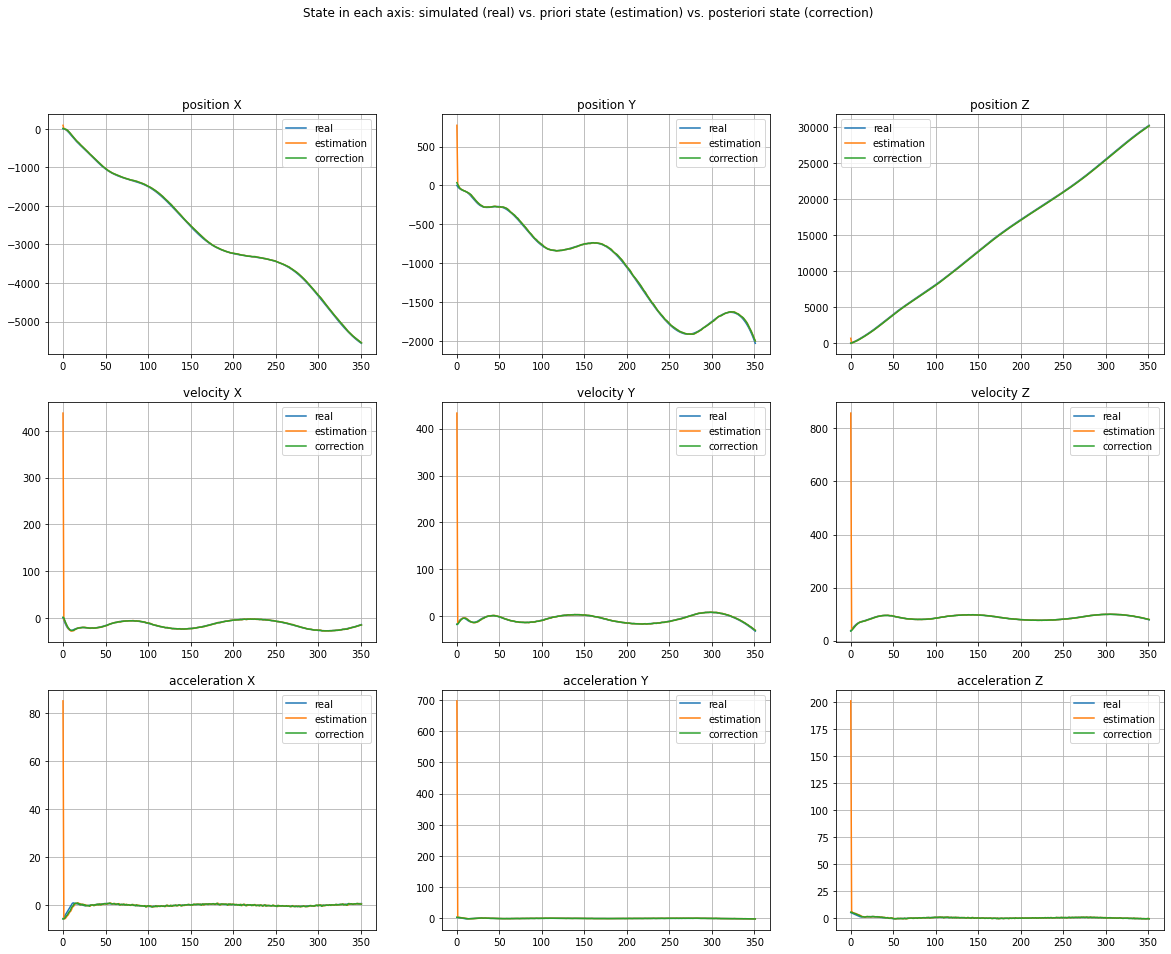

In [330]:
## Comparación señal simulada real vs señal medida con ruido gaussiano vs. posición estimada vs. posición corregida
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(3, 3, figsize=(20,15))
fig.suptitle('State in each axis: simulated (real) vs. priori state (estimation) vs. posteriori state (correction)')

for i in range(len(axs)):
    for j in range(len(axs[i])):
        axs[i,j].plot(x_scale, X[:,3*i+j])
        axs[i,j].plot(x_scale, x_priori_pv[:,3*i+j])
        axs[i,j].plot(x_scale, x_posteriori_pv[:,3*i+j])
        axs[i,j].legend(["real", "estimation", "correction"], loc='best')
        axs[i,j].grid()
        title = ''
        if i == 0:
            title = 'position'
        elif i == 1:
            title = 'velocity'
        elif i == 2:
            title = 'acceleration'
        if j == 0:
            title += ' X'
        elif j == 1:
            title += ' Y'
        elif j == 2:
            title += ' Z'
        
        axs[i,j].set_title(title)

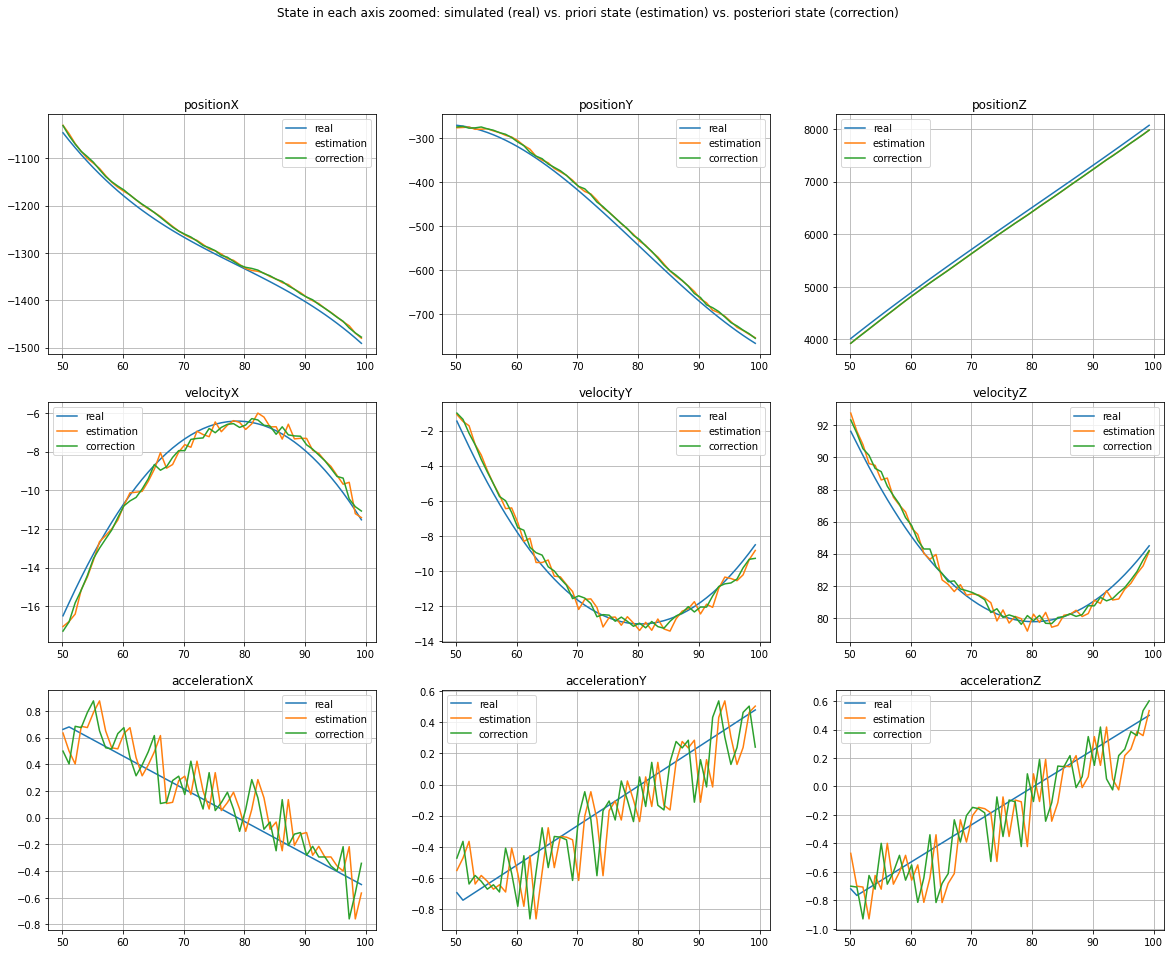

In [331]:
## (Zoom) Comparación señal simulada real vs señal medida con ruido gaussiano vs. posición estimada vs. posición corregida
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(3, 3, figsize=(20,15))
fig.suptitle('State in each axis zoomed: simulated (real) vs. priori state (estimation) vs. posteriori state (correction)')

for i in range(len(axs)):
    for j in range(len(axs[i])):
        axs[i,j].plot(x_scale[50:100], X[50:100,3*i+j])
        axs[i,j].plot(x_scale[50:100], x_priori_pv[50:100,3*i+j])
        axs[i,j].plot(x_scale[50:100], x_posteriori_pv[50:100,3*i+j])
        axs[i,j].legend(["real", "estimation", "correction"], loc='best')
        axs[i,j].grid()
        title = ''
        if i == 0:
            title = 'position'
        elif i == 1:
            title = 'velocity'
        elif i == 2:
            title = 'acceleration'
        if j == 0:
            title += 'X'
        elif j == 1:
            title += 'Y'
        elif j == 2:
            title += 'Z'
        
        axs[i,j].set_title(title)

#### Conclusión
En estos gráficos se puede ver que la estimación tanto a priori como a posteriori de la velocidad han mejorado considerablemente. Resulta lógico que esto ocurra ya que ahora se tiene una información directa del sensor que permite al sistema ser más preciso. En el caso de la aceleración también se mejora la estimación aunque puede verse que hay margen de mejora si se alimentara al sistema con mediciones de esta variable.

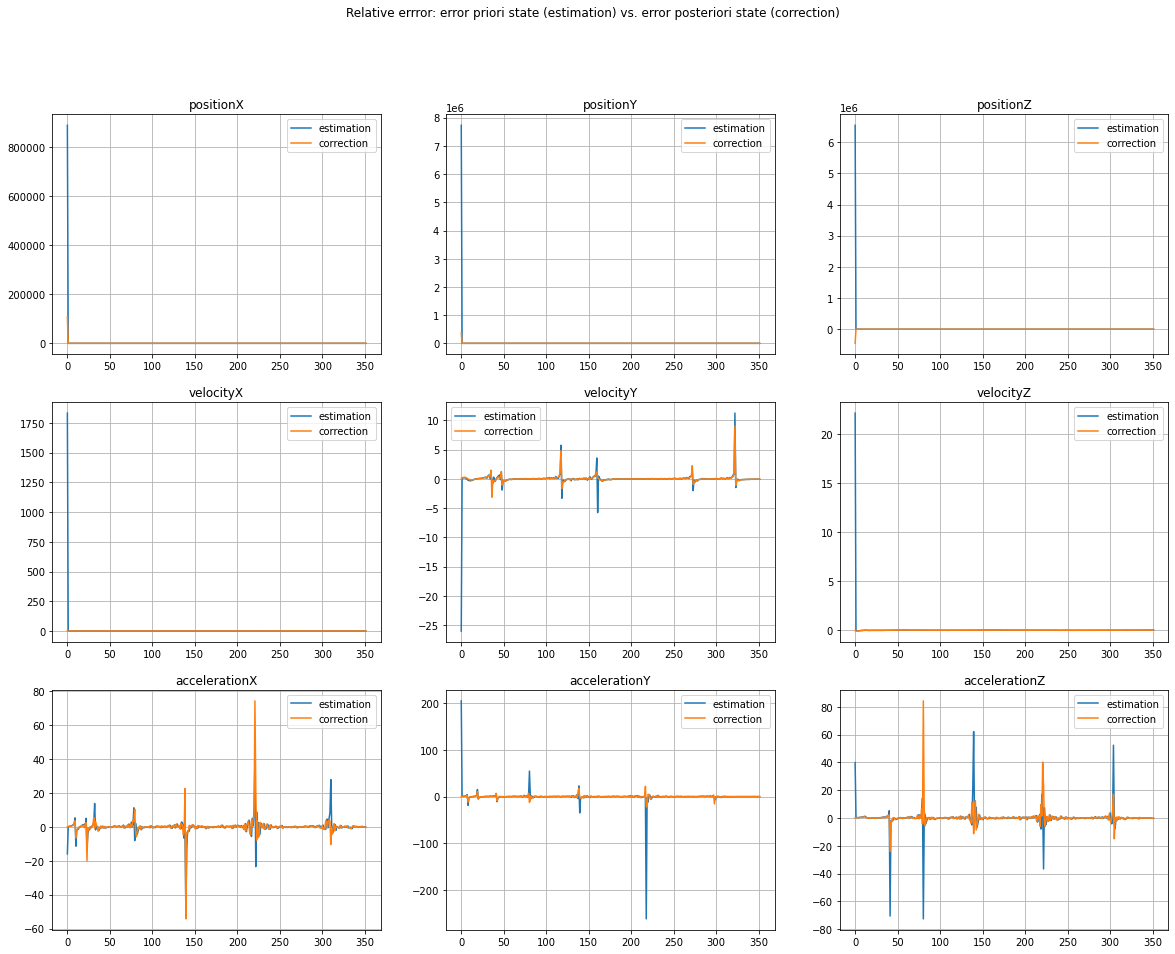

In [332]:
## Error estimación a priori vs estimación a posteriori
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(3, 3, figsize=(20,15))
fig.suptitle('Relative errror: error priori state (estimation) vs. error posteriori state (correction)')

for i in range(len(axs)):
    for j in range(len(axs[i])):
        axs[i,j].plot(x_scale, (x_priori_pv[:,3*i+j] - X[:,3*i+j]) / (X[:,3*i+j]+0.0001) )
        axs[i,j].plot(x_scale, (x_posteriori_pv[:,3*i+j] - X[:,3*i+j]) / (X[:,3*i+j]+0.0001) )
        axs[i,j].legend(["estimation", "correction"], loc='best')
        axs[i,j].grid()
        title = ''
        if i == 0:
            title = 'position'
        elif i == 1:
            title = 'velocity'
        elif i == 2:
            title = 'acceleration'
        if j == 0:
            title += 'X'
        elif j == 1:
            title += 'Y'
        elif j == 2:
            title += 'Z'
        
        axs[i,j].set_title(title)

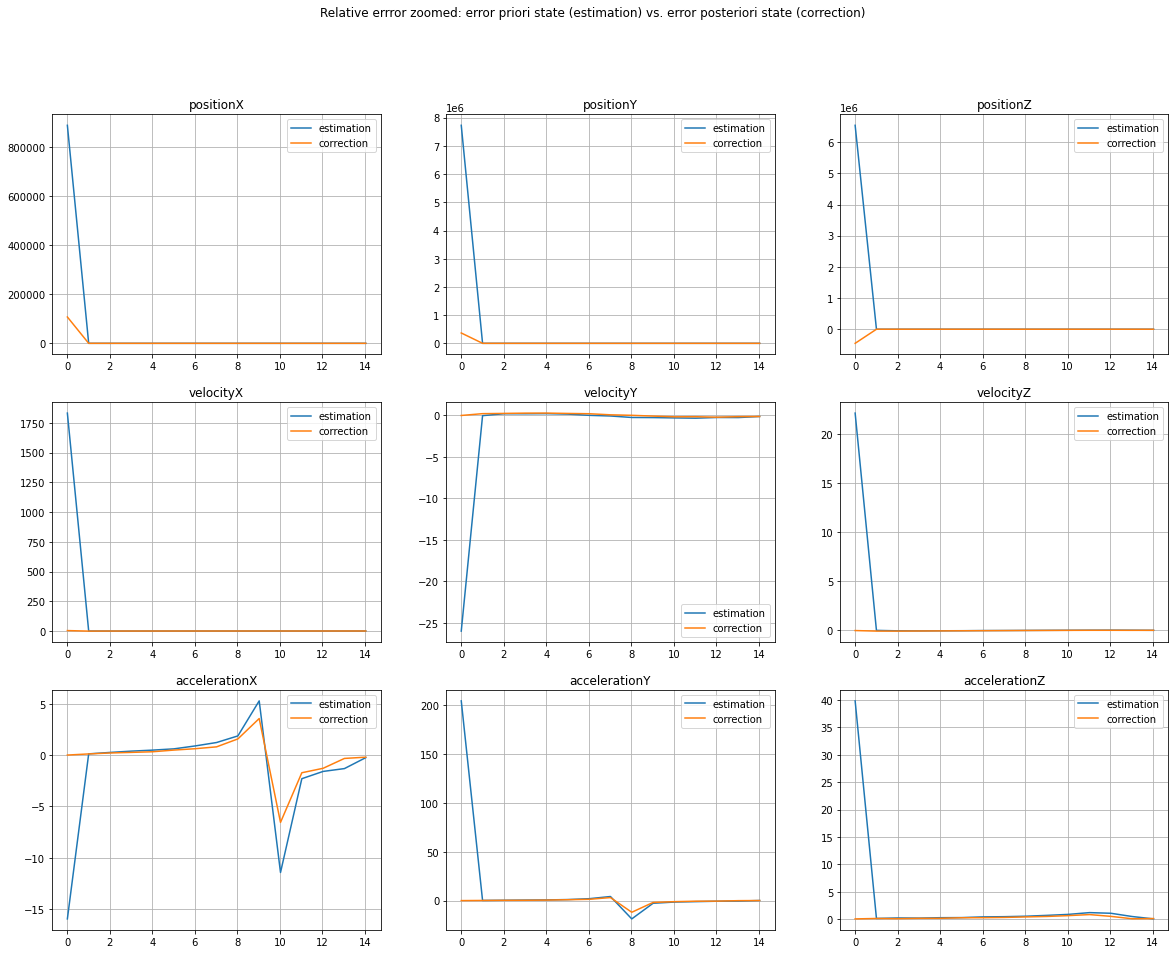

In [333]:
## (Zoomed) Error estimación a priori vs estimación a posteriori
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(3, 3, figsize=(20,15))
fig.suptitle('Relative errror zoomed: error priori state (estimation) vs. error posteriori state (correction)')

for i in range(len(axs)):
    for j in range(len(axs[i])):
        axs[i,j].plot(x_scale[:15], (x_priori_pv[:15,3*i+j] - X[:15,3*i+j]) / (X[:15,3*i+j]+0.0001) )
        axs[i,j].plot(x_scale[:15], (x_posteriori_pv[:15,3*i+j] - X[:15,3*i+j]) / (X[:15,3*i+j]+0.0001) )
        axs[i,j].legend(["estimation", "correction"], loc='best')
        axs[i,j].grid()
        title = ''
        if i == 0:
            title = 'position'
        elif i == 1:
            title = 'velocity'
        elif i == 2:
            title = 'acceleration'
        if j == 0:
            title += 'X'
        elif j == 1:
            title += 'Y'
        elif j == 2:
            title += 'Z'
        
        axs[i,j].set_title(title)

#### Conlusión
Al igual que antes, al principio, el error relativo es los instantes iniciales depende mucho de las condiciones iniciales. Una vez que el sistema se estabiliza el error relativo de una y otra medición tienden a cero. Esto sucede gracias a la matriz de ganancia K. En los momentos iniciales, como la estimación es mala, la matriz P tendrá valores grandes. Dichos valores impactan en un incremento de la matriz K que hacen que se le de mucha más ponderancia a las nuevas estimaciones, lo cual lleva rápidamente al sistema a corregirse.

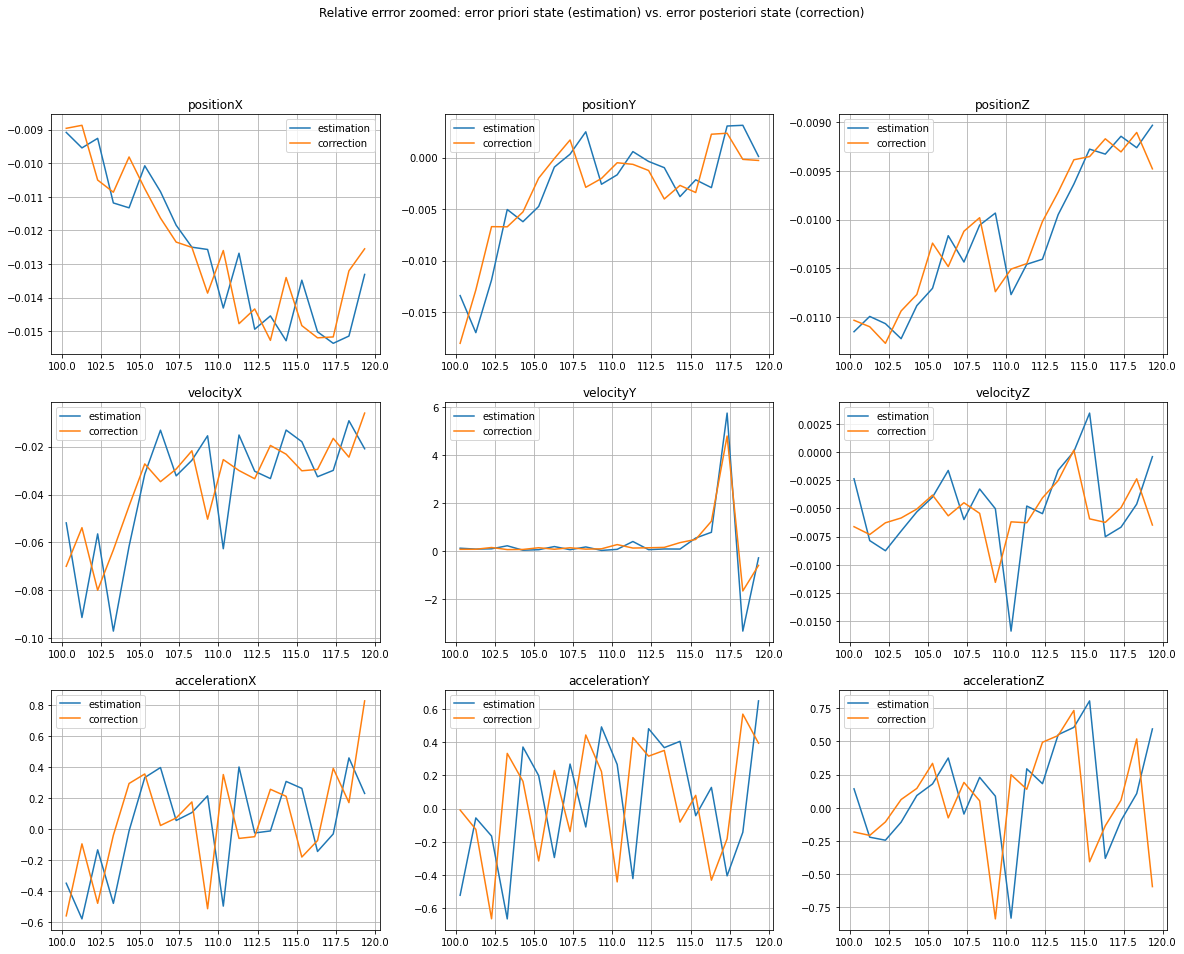

In [334]:
## (Zoomed 2) Error estimación a priori vs estimación a posteriori
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(3, 3, figsize=(20,15))
fig.suptitle('Relative errror zoomed: error priori state (estimation) vs. error posteriori state (correction)')

for i in range(len(axs)):
    for j in range(len(axs[i])):
        axs[i,j].plot(x_scale[100:120], (x_priori_pv[100:120,3*i+j] - X[100:120,3*i+j]) / (X[100:120,3*i+j]+0.0001) )
        axs[i,j].plot(x_scale[100:120], (x_posteriori_pv[100:120,3*i+j] - X[100:120,3*i+j]) / (X[100:120,3*i+j]+0.0001) )
        axs[i,j].legend(["estimation", "correction"], loc='best')
        axs[i,j].grid()
        title = ''
        if i == 0:
            title = 'position'
        elif i == 1:
            title = 'velocity'
        elif i == 2:
            title = 'acceleration'
        if j == 0:
            title += 'X'
        elif j == 1:
            title += 'Y'
        elif j == 2:
            title += 'Z'
        
        axs[i,j].set_title(title)

#### Conclusión
Al igual que en el análisis de las variables de estado, pareciera verse que las gráficas correspondientes al error relativo de la estimación a priori están decaladas en el tiempo respecto al error relativo de la estimación a posteriori. Esto puede verse en las gráficas de la aceleración principalmente. Tiene sentido que así sea ya que, al no tener información directa del sensor acerca de estas variables, serán una estimación a lo largo de todo instante de tiempo k y es lógico que la estimación en el instante k tome un valor muy similar a la estimación en el instante k-1 si el error en ese instante ha sido pequeño.

Text(0.5, 1.0, 'Mean squared error')

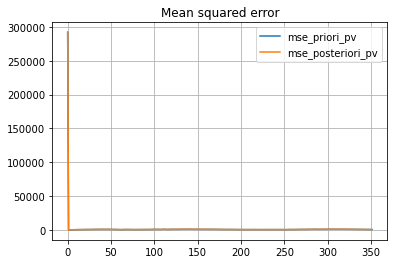

In [335]:
## Error cuadrático medio del estado
x_scale = np.linspace(0, n_samples, num=n_samples)

mse_priori_pv = np.square(x_priori_pv - X).mean(axis=1)
mse_posteriori_pv = np.square(x_posteriori_pv - X).mean(axis=1)

plt.plot(x_scale, mse_priori_pv, mse_priori_pv)
plt.legend(['mse_priori_pv', 'mse_posteriori_pv'])
plt.grid()
plt.title('Mean squared error')

Text(0.5, 1.0, 'Mean squared error zoomed')

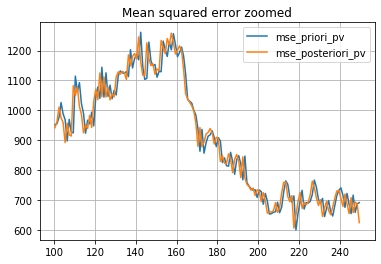

In [336]:
## Error cuadrático medio del estado (zoom)
x_scale = np.linspace(0, n_samples, num=n_samples)

mse_priori_pv = np.square(x_priori_pv - X).mean(axis=1)
mse_posteriori_pv = np.square(x_posteriori_pv - X).mean(axis=1)

plt.plot(x_scale[100:250], mse_priori_pv[100:250])
plt.plot(x_scale[100:250], mse_posteriori_pv[100:250])
plt.legend(['mse_priori_pv', 'mse_posteriori_pv'])
plt.grid()
plt.title('Mean squared error zoomed')

Text(0.5, 1.0, 'mse etimations')

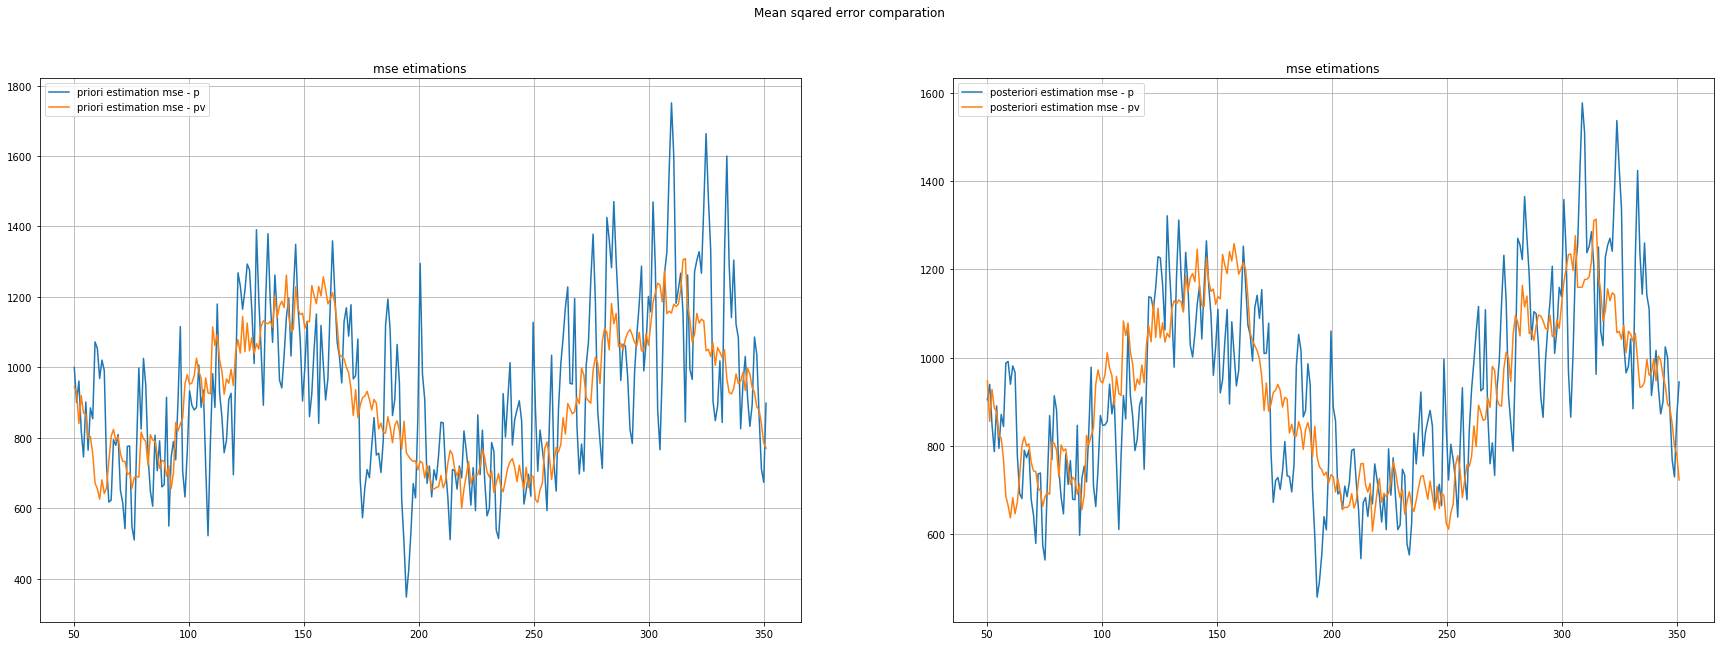

In [337]:
# Comparación de los errores cuadráticos medios.
## Error cuadrático medio del estado (zoom)
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(1, 2, figsize=(30,10))
fig.suptitle('Mean sqared error comparation')

axs[0].plot(x_scale[50:], mse_priori[50:] )
axs[0].plot(x_scale[50:], mse_priori_pv[50:] )
axs[0].legend(["priori estimation mse - p", "priori estimation mse - pv"], loc='best')
axs[0].grid()
axs[0].set_title("mse etimations")

axs[1].plot(x_scale[50:], mse_posteriori[50:] )
axs[1].plot(x_scale[50:], mse_posteriori_pv[50:] )
axs[1].legend(["posteriori estimation mse - p", "posteriori estimation mse - pv"], loc='best')
axs[1].grid()
axs[1].set_title("mse etimations")

### Comparación trazas de la matriz $P_{k|k-1}$ y $P_{k|k}$

In [338]:
## Trazas matriz P
tr_p_priori_pv = np.trace(P_priori_pv, axis1=1, axis2=2)
tr_p_posteriori_pv = np.trace(P_posteriori_pv, axis1=1, axis2=2)

Text(0.5, 1.0, 'Error: priori estimation vs. posteriori estimation')

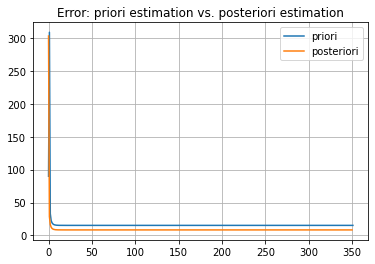

In [339]:
## Error
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, ax = plt.plot(x_scale, tr_p_priori_pv, tr_p_posteriori_pv)
plt.legend(["priori", "posteriori"], loc='best')
plt.grid()
plt.title("Error: priori estimation vs. posteriori estimation")

#### Conclusión
Al igual que con el anális anterior con perturbaciones gaussianas, se puede observar que el error de estimación a posteriori filtrado y corregido es menor que el error de estimación a priori en todo momento. Se concluye así que la mejor estimación es la estimación a posteriori. 

Text(0.5, 1.0, 'error posteriori etimations')

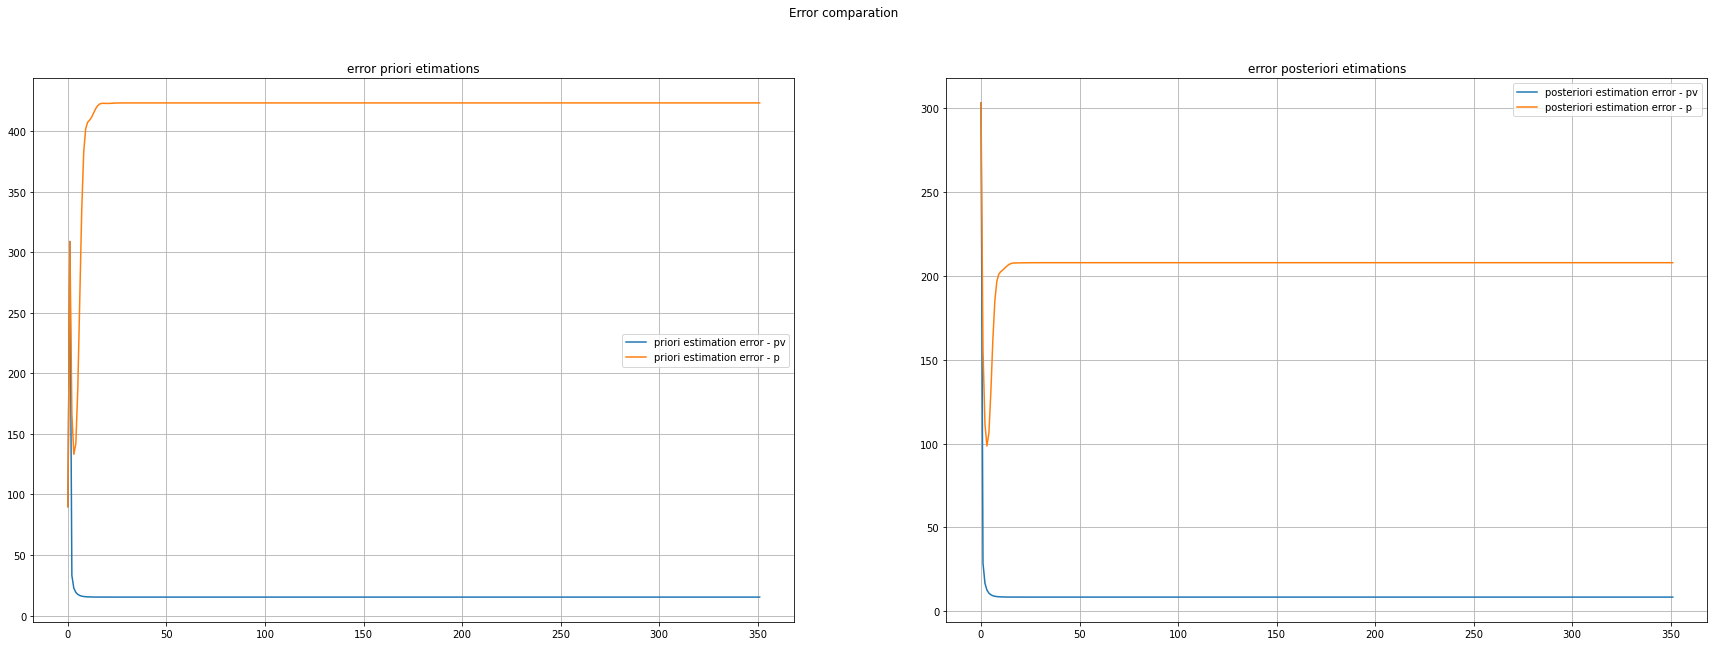

In [340]:
# Comparación de una y otra perturbación
## Error verdadero
x_scale = np.linspace(0, n_samples, num=n_samples)
fig, axs = plt.subplots(1, 2, figsize=(30,10))
fig.suptitle('Error comparation')

axs[0].plot(x_scale, tr_p_priori_pv )
axs[0].plot(x_scale, tr_p_priori_gauss_pos )
axs[0].legend(["priori estimation error - pv", "priori estimation error - p"], loc='best')
axs[0].grid()
axs[0].set_title("error priori etimations")

axs[1].plot(x_scale, tr_p_posteriori_pv )
axs[1].plot(x_scale, tr_p_posteriori_gauss_pos )
axs[1].legend(["posteriori estimation error - pv", "posteriori estimation error - p"], loc='best')
axs[1].grid()
axs[1].set_title("error posteriori etimations")

#### Conlusión
Con las gráficas ilustradas no se puede afirmar que medir más variables de estados aumenta considerablemente la presición del sistema y disminuye considerablemente el error.

### 4. Correlación entre innovaciones

In [341]:
from statsmodels.graphics.tsaplots import plot_acf

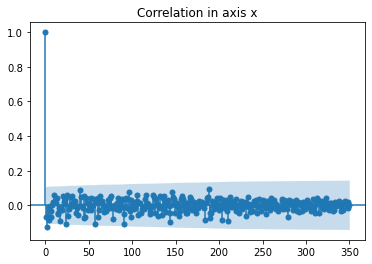

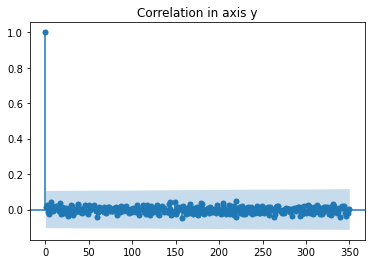

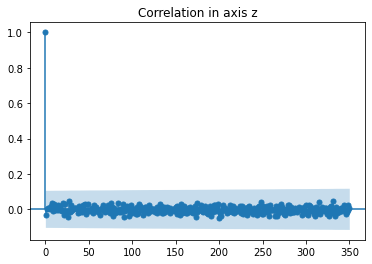

In [342]:
e = y - y_priori
lag_len = e.shape[0] - 1
axis_dict={0: 'x', 1: 'y', 2: 'z'}

for dim in range(e.shape[1]):
    plot_acf(e[:,dim], lags=lag_len, title=f"Correlation in axis {axis_dict[dim]}")


#### Conlusión
En el gráfico anterior se puede ver que el valor 1 se da en la absisa 0 porque es la correlación de una innovación consigo misma. En el resto de las absisas la correlación es prácticamente nula. Esto quiere decir que las innovaciones son independientes entre sí. Esto tiene sentido ya que la formulación del filtro de Kalman supone que todas las innovaciones son ortogonales entre sí y esto de por sí implica descorrelación. La correlación no es exactamente nula porque, por la incertidumbre que tiene el propio sistema y por los errores de las proyecciones ortogonales, una innovación (que tiene en ella información de las innovaciones) puede no ser 100% ortogonal a las otras.